# Imports & Setup

In [51]:
import pathlib
import pyperclip
import matplotlib
import curie as ci
import numpy as np
import pandas as pd
from tendl import Tendl
import periodictable as pt
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import curve_fit
from typing import Literal, Iterable
from uncertainties.umath import exp as uexp
from uncertainties import ufloat, correlated_values, unumpy

%matplotlib inline
matplotlib.rcParams.update({
                            'font.size': 14,
                            'axes.labelsize':   13,
                            'axes.titlesize': 16, 
                            'xtick.labelsize': 12, 
                            'ytick.labelsize': 12, 
                            'legend.fontsize': 10,
                            'figure.titlesize': 16,
                            'figure.figsize': (14, 8)
                           })

     

class Path(pathlib.Path):
    '''Wrapper for pathlib.Path to ensure string representation is used in Spectrum class.'''
    def endswith(self, suffix):
        return str(self).endswith(suffix)
    
    def split(self, sep=None):
        return str(self).split(sep)
    
    def __add__(self, other: str):
        return Path(str(self) + other)
    
    def __radd__(self, other: str):
        return Path(other + str(self))
    
root_path = Path.cwd().parent 

spec_filename   = root_path / 'spectra'
spec_calib_path = spec_filename / 'calibration'
spec_exp_path   = spec_filename / 'experiment'
spec_test_path  = spec_filename / 'test'
tendl_data_path = root_path / 'tendl_data'
fig_path        = root_path / 'figs'

## Calibration

### Plotting Efficiency Curve

In [52]:
calib_path_Cs = spec_calib_path / 'AA110625_Cs137.Spe'
calib_path_Ba = spec_calib_path / 'AB110625_Ba133.Spe'
calib_path_Eu = spec_calib_path / 'AC110625_Eu152.Spe'

# Extract the spectrums for calibration
cb = ci.Calibration()
sp_Cs137 = ci.Spectrum(calib_path_Cs)
sp_Ba133 = ci.Spectrum(calib_path_Ba)
sp_Eu152 = ci.Spectrum(calib_path_Eu)

# Assign isotopes to the spectrums. Our calibration samples are 100% Cs137, Ba133, and Eu152
# Note: Isotope names must be uppercase
sp_Cs137.isotopes = ['137CS']
sp_Ba133.isotopes = ['133BA']
sp_Eu152.isotopes = ['152EU']


def Ci_to_Bq(Ci):
    """Convert Curie to Becquerel."""
    return Ci * 3.7e10  # 1 Ci = 3.7e10 Bq

# Add information about the sources
# Note: Isotope names must be uppercase
sources = [
    {'isotope': '133BA',
     'A0': Ci_to_Bq(10.78*1e-6),
     'ref_date': '10/01/1988 12:00:00'},
    {'isotope': '137CS', 
     'A0': Ci_to_Bq(11.46*1e-6), 
     'ref_date': '02/01/1979 12:00:00'},
    {'isotope': '152EU',
     'A0': 150*1e3,
     'ref_date': '01/01/2002 12:00:00'}
]

sources = pd.DataFrame(sources)
cb.calibrate([sp_Ba133, sp_Cs137, sp_Eu152], sources=sources)
# cb.saveas(root_path / 'calibration.json')

Reading Spectrum /home/oskar/repos/summer_project/spectra/calibration/AA110625_Cs137.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/calibration/AB110625_Ba133.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/calibration/AC110625_Eu152.Spe


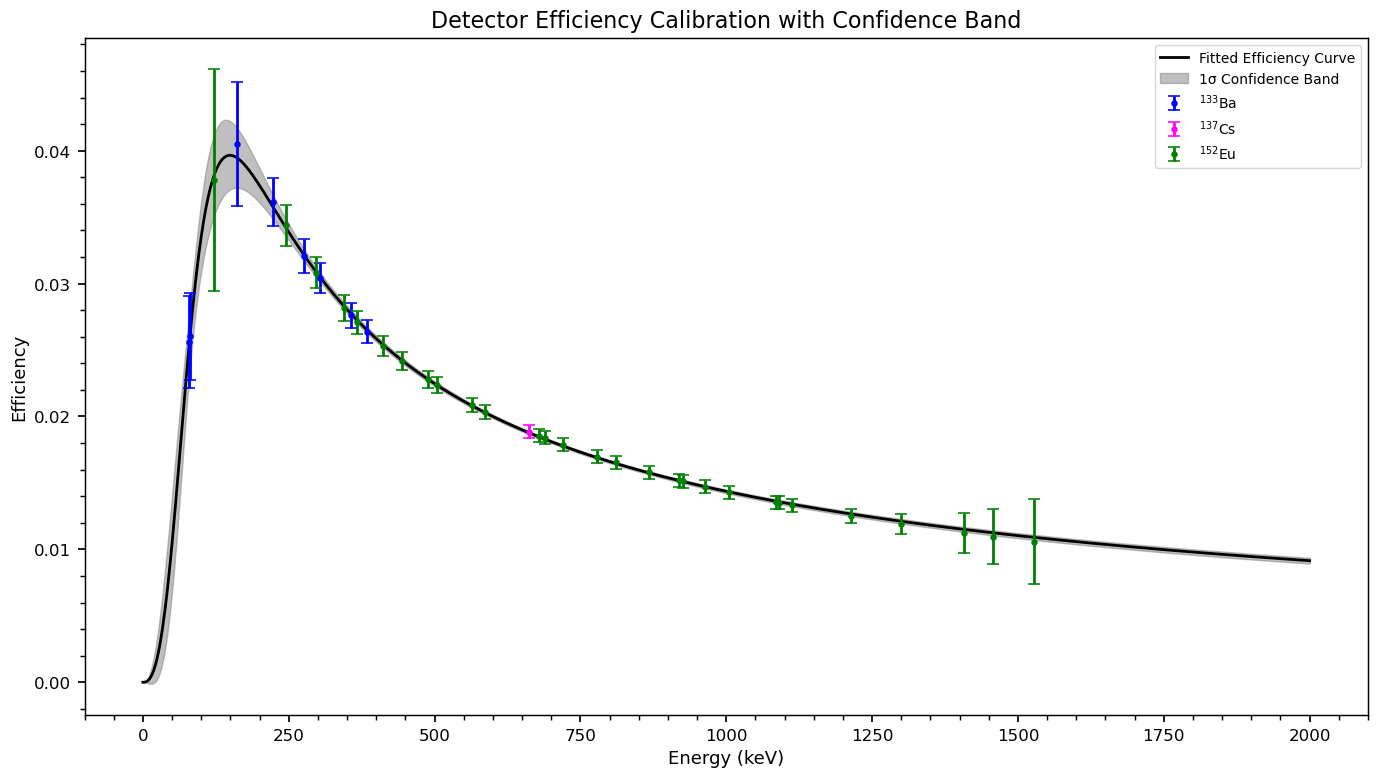

In [109]:
isotope_energy_set = []
efficiencies = []
unc_efficiencies = []
isotopes = []

for sp in [sp_Ba133, sp_Cs137, sp_Eu152]:
    for energy, ε, unc_ε, iso_name in zip(sp.peaks['energy'], sp.peaks['efficiency'], sp.peaks['unc_efficiency'], sp.peaks['isotope']):
        isotope_energy_set.append(energy)
        efficiencies.append(ε)
        unc_efficiencies.append(unc_ε)
        isotopes.append(iso_name)

isotope_energy_set = np.array(isotope_energy_set)
efficiencies = np.array(efficiencies)
unc_efficiencies = np.array(unc_efficiencies)
        
def efficiency_curve(E, a, b, c, d):
    return a * E**b/(c + E**d)

# Fit the efficiency data to the model
p0 = [20, 1, 5e+4, 2]  # Initial guess for parameters from testing parameters manually
efficiency_curve_params, cov = curve_fit(efficiency_curve, isotope_energy_set, efficiencies, p0=[20, 1, 5e+4, 2], sigma=unc_efficiencies, absolute_sigma=True)

energy_range = np.linspace(0, 2000, 1000)
fitted_efficiency = efficiency_curve(energy_range, *efficiency_curve_params)

# Create correlated ufloat objects for the fitted parameters
u_efficiency_curve_params = correlated_values(efficiency_curve_params, cov)
# Calculate the fitted efficiency with uncertainties
u_fitted_efficiency = efficiency_curve(energy_range, *u_efficiency_curve_params)
# Extract nominal values and standard deviations
fitted_efficiency_nom = unumpy.nominal_values(u_fitted_efficiency)
fitted_efficiency_std = unumpy.std_devs(u_fitted_efficiency)



# Plotting the confidence band
plt.plot(energy_range, fitted_efficiency_nom, color='black', label='Fitted Efficiency Curve')
plt.fill_between(energy_range, 
                 fitted_efficiency_nom - fitted_efficiency_std, 
                 fitted_efficiency_nom + fitted_efficiency_std, 
                 color='gray', alpha=0.5, label='1σ Confidence Band')

plt.errorbar(sp_Ba133.peaks['energy'], sp_Ba133.peaks['efficiency'], yerr=sp_Ba133.peaks['unc_efficiency'], fmt='o', label=r'$^{133}$Ba', color='blue')
plt.errorbar(sp_Cs137.peaks['energy'], sp_Cs137.peaks['efficiency'], yerr=sp_Cs137.peaks['unc_efficiency'], fmt='o', label=r'$^{137}$Cs', color='magenta')
plt.errorbar(sp_Eu152.peaks['energy'], sp_Eu152.peaks['efficiency'], yerr=sp_Eu152.peaks['unc_efficiency'], fmt='o', label=r'$^{152}$Eu', color='green')

plt.xlabel('Energy (keV)')
plt.ylabel('Efficiency')
plt.title('Detector Efficiency Calibration with Confidence Band')
plt.legend()
plt.show()

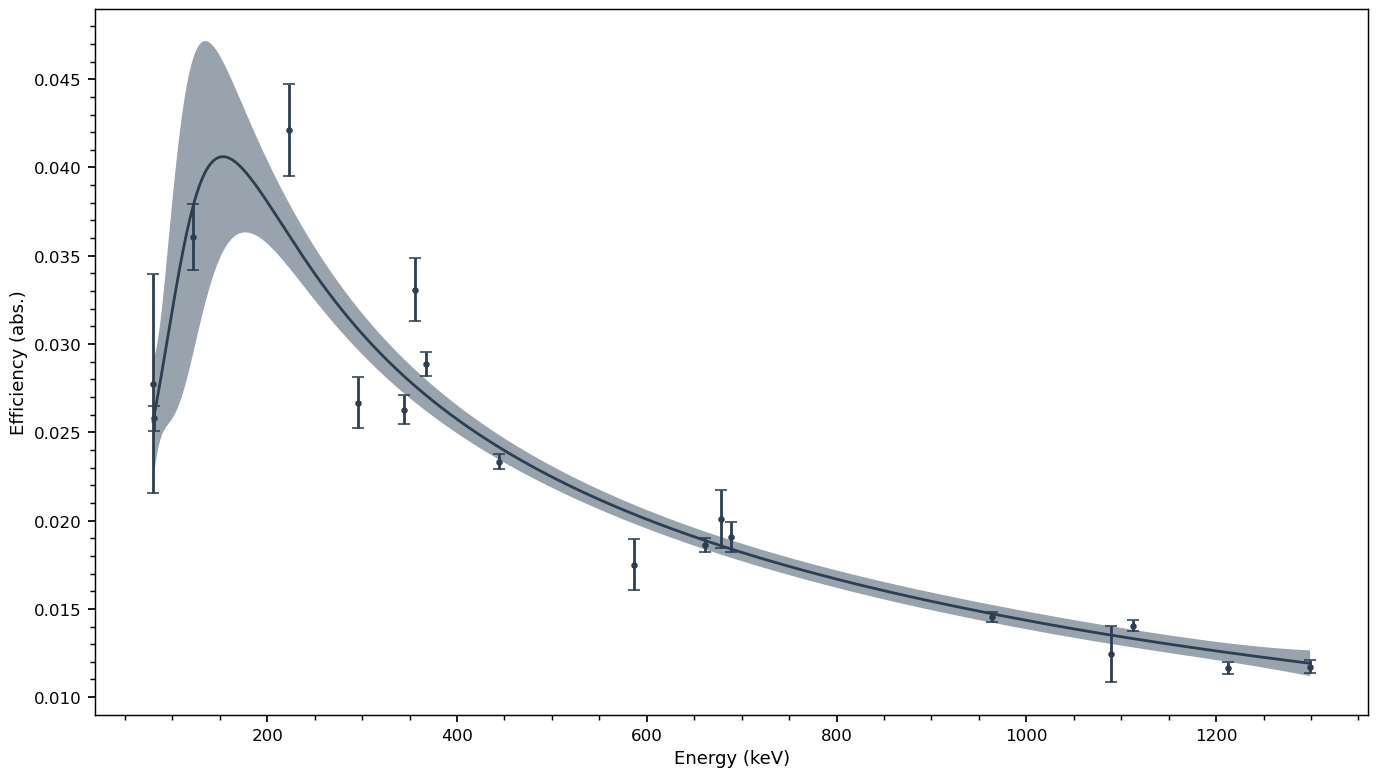

In [106]:
cb.plot_effcal()

# Part 1: Finding Initial Activity

## Testing

<Figure size 1400x800 with 0 Axes>

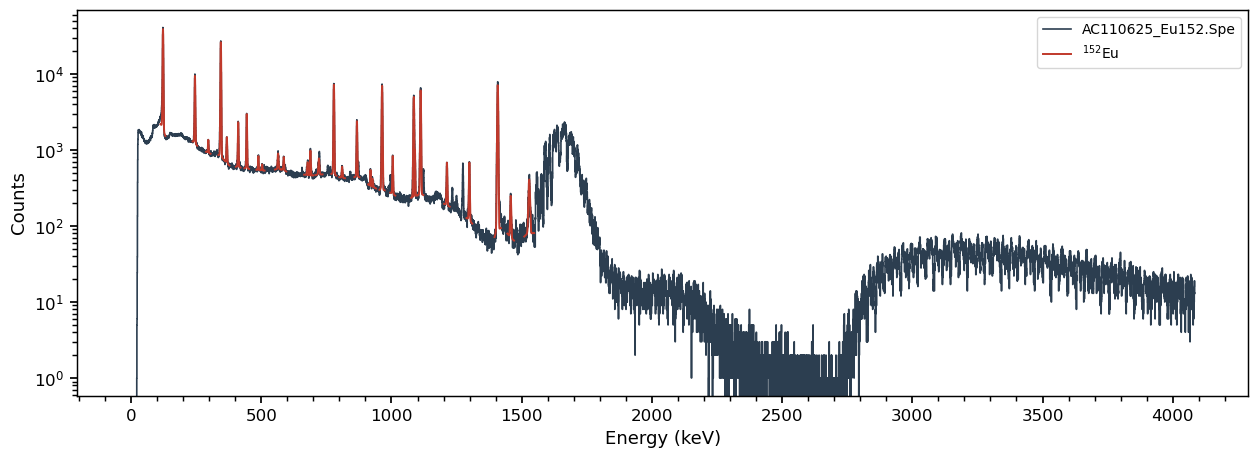

In [54]:
sp_Eu152.cb = cb
plt.clf()
fig, ax = sp_Eu152.plot(return_plot=True)

In [55]:
# sp_Eu152.sumamrize()
a = set()
a.update(zip(sp_Ba133.peaks['energy'].array, sp_Ba133.peaks['isotope'].array))
print(a)
print(*sp_Ba133.peaks['energy'].array)

{(356.0129, '133BA'), (79.6142, '133BA'), (223.2368, '133BA'), (80.9979, '133BA'), (276.3989, '133BA'), (383.8485, '133BA'), (302.8508, '133BA'), (160.612, '133BA')}
79.6142 80.9979 160.612 223.2368 276.3989 302.8508 356.0129 383.8485


In [56]:
def energy_data(sp: ci.Spectrum) -> list[tuple[float, dict]]:
    """Extract energy from Spectrum object""" 
    energies = []
    for E, iso, N_c, unc_N_c, I, unc_I, ε, unc_ε, λ, unc_λ, rt, lt in zip(sp.peaks['energy'].array, sp.peaks['isotope'],
                                                                     sp.peaks['counts'].array, sp.peaks['unc_counts'].array, 
                                                                     sp.peaks['intensity'].array, sp.peaks['unc_intensity'].array, 
                                                                     sp.peaks['efficiency'].array, sp.peaks['unc_efficiency'].array, sp.peaks['decay_rate'].array, sp.peaks['unc_decay_rate'].array, 
                                                                     sp.peaks['real_time'].array, sp.peaks['live_time'].array
                                                          ):
        data = {
            'isotope': iso,
            'counts': N_c,
            'unc_counts': unc_N_c,
            'intensity': I,
            'unc_intensity': unc_I,
            'efficiency': ε,
            'unc_efficiency': unc_ε,
            # 'decay_rate': λ,
            # 'unc_decay_rate': unc_λ,
            'real_time': rt,
            'live_time': lt    
        }
        data['decay_rate'] = ci.Isotope(iso).decay_const()
        
        
        energies.append((E, data))
        
    return energies


def Activity(t, A0, λ):
    return A0*np.exp(-λ*t)

In [57]:
job_name = 'job1_Ag4_1min_real10_loop6_'
spec_filename = spec_exp_path / (job_name + '001.Spe')

sp = ci.Spectrum(spec_filename)
# Note: Can use the calibration object created above, but we already saved it to a file
# sp.cb = cb
sp.cb = ci.Calibration(root_path / 'calibration.json')
sp.isotopes = ['108AG', '110AG']

print('Energies and counts:')
isotope_energy_set = energy_data(sp)
print(isotope_energy_set)

# sp.plot(return_plot=True)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_001.Spe
Energies and counts:
[(433.96, {'isotope': '108AG', 'counts': 26.66623270881777, 'unc_counts': 5.846834261363426, 'intensity': 0.005, 'unc_intensity': 0.00025, 'efficiency': 0.02450041949967394, 'unc_efficiency': 0.0007184038689308501, 'real_time': 10.0, 'live_time': 9.0, 'decay_rate': 0.004849896309543418}), (632.98, {'isotope': '108AG', 'counts': 31.873431083603947, 'unc_counts': 5.528830490963141, 'intensity': 0.0176, 'unc_intensity': 0.001, 'efficiency': 0.019405772268799335, 'unc_efficiency': 0.0005125029458983969, 'real_time': 10.0, 'live_time': 9.0, 'decay_rate': 0.004849896309543418}), (657.5, {'isotope': '110AG', 'counts': 320.5436318783905, 'unc_counts': 14.970488234371642, 'intensity': 0.045, 'unc_intensity': 0.0022500000000000003, 'efficiency': 0.01894346257453844, 'unc_efficiency': 0.0005046895008075428, 'real_time': 10.0, 'live_time': 9.0, 'decay_rate': 0.02817671465690

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_001.Spe


/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_002.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_003.Spe


/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_004.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_005.Spe


/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


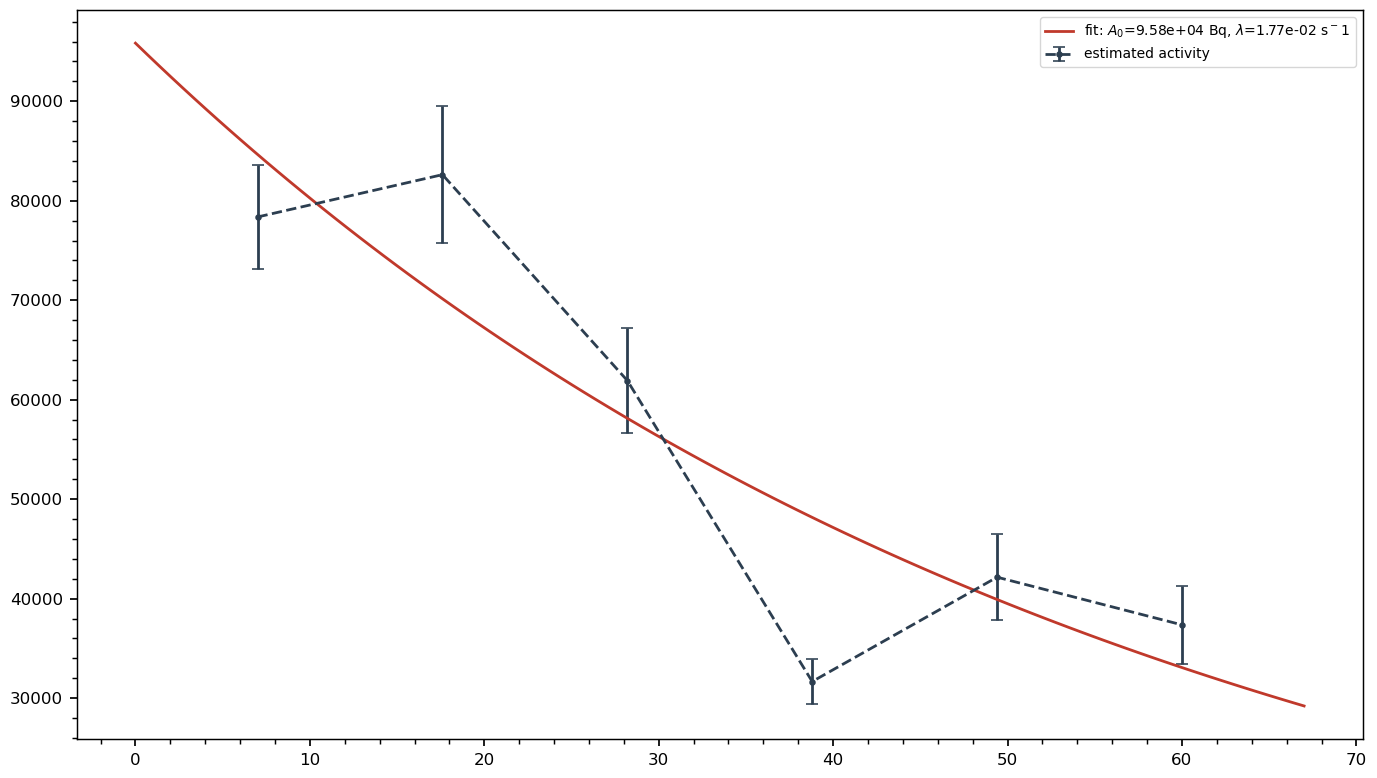

In [58]:
job_name = 'job1_Ag4_1min_real10_loop6_'
activities = []
uncertancies = []

n_loops = 6
for i in range(n_loops):
    spec_filename = spec_exp_path / (job_name + f'{i:03d}.Spe')
    sp5 = ci.Spectrum(spec_filename)
    sp5.cb = ci.Calibration(root_path / 'calibration.json')
    sp5.isotopes = ['108AG', '110AG']
    
    A = ufloat(0, 0)
    for energy, data in energy_data(sp5):
        isotope = data['isotope']
        N_c     = data['counts']
        unc_N_c = data['unc_counts']
        λ       = data['decay_rate']
        I_γ     = data['intensity']
        unc_I_γ = data['unc_intensity']   
        ε       = data['efficiency']
        unc_ε   = data['unc_efficiency']
        Δt_c    = data['live_time']
        Δt_r    = data['real_time']
        
        N_c_u = ufloat(N_c, unc_N_c)
        I_γ_u = ufloat(I_γ, unc_I_γ)
        ε_u   = ufloat(ε, unc_ε)
        
        A += (N_c_u * λ)/(ε_u*I_γ_u*(1 - uexp(-λ*Δt_c)))

     
     
    activities.append(A.nominal_value)
    uncertancies.append(A.std_dev) 
    # activities.append(A/Δt_r) ? 
plt.clf()

isotope_energy_set = energy_data(sp5)
period = data['real_time']
start = 7 # s
real_times = np.linspace(start, n_loops*period, n_loops)
actual_time = np.linspace(0, start + n_loops*period, 100)

p0 = (1000, 0.01)
activity_curve_params, cv = curve_fit(Activity, real_times, activities, p0=p0)
A0, λ = activity_curve_params

plt.clf()
plt.errorbar(real_times, activities, yerr=uncertancies, fmt='o--', label = 'estimated activity')
plt.plot(actual_time, Activity(actual_time, A0, λ), label = fr'fit: $A_0$={A0:.2e} Bq, $λ$={λ:.2e} s$^{-1}$')

plt.legend()
plt.show()

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_002.Spe


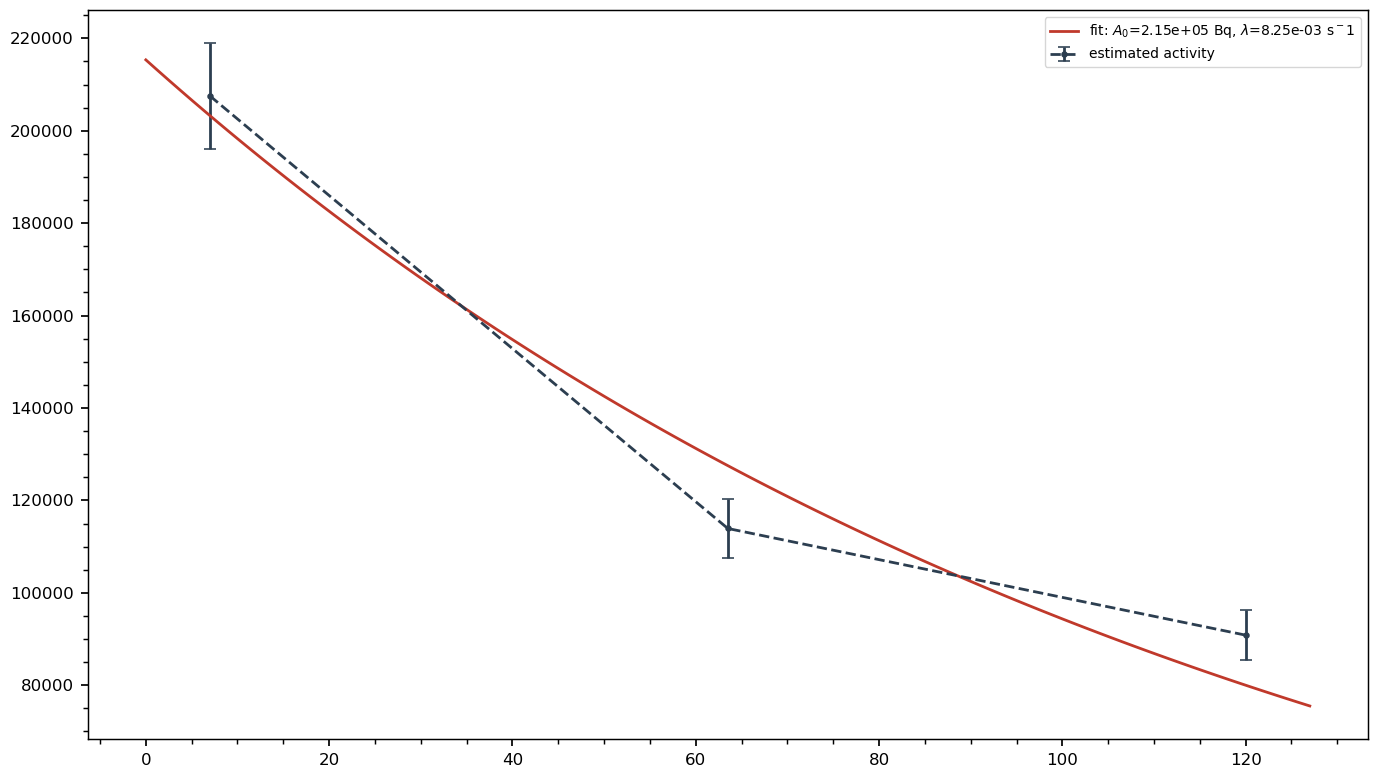

In [59]:
job_name = 'job3_Ag73_3min_real40_loop3_'
activities = []
uncertancies = []

n_loops = 3
for i in range(n_loops):
    spec_filename = spec_exp_path / (job_name + f'{i:03d}.Spe')
    sp5 = ci.Spectrum(spec_filename)
    sp5.cb = ci.Calibration(root_path / 'calibration.json')
    sp5.isotopes = ['108AG', '110AG']
    
    A = ufloat(0, 1e-16) # Small uncertainty to avoid warning
    for energy, data in energy_data(sp5):
        isotope = data['isotope']
        N_c     = data['counts']
        unc_N_c = data['unc_counts']
        λ       = data['decay_rate']
        I_γ     = data['intensity']
        unc_I_γ = data['unc_intensity']   
        ε       = data['efficiency']
        unc_ε   = data['unc_efficiency']
        Δt_c    = data['live_time']
        Δt_r    = data['real_time']
        
        N_c_u = ufloat(N_c, unc_N_c)
        I_γ_u = ufloat(I_γ, unc_I_γ)
        ε_u   = ufloat(ε, unc_ε)
        
        A += (N_c_u * λ)/(ε_u*I_γ_u*(1 - uexp(-λ*Δt_c)))

     
     
    activities.append(A.nominal_value)
    uncertancies.append(A.std_dev)
    # TODO normalize to real time ?
    # activities.append(A/Δt_r)
plt.clf()

isotope_energy_set = energy_data(sp5)
period = data['real_time']
start = 7 # s
real_times = np.linspace(start, n_loops*period, n_loops)
actual_time = np.linspace(0, start + n_loops*period, 100)

p0 = (1000, 0.01)
activity_curve_params, cv = curve_fit(Activity, real_times, activities, p0=p0)
A0, λ = activity_curve_params


plt.clf()
plt.errorbar(real_times, activities, yerr=uncertancies, fmt='o--', label = 'estimated activity')
plt.plot(actual_time, Activity(actual_time, A0, λ), label = fr'fit: $A_0$={A0:.2e} Bq, $λ$={λ:.2e} s$^{-1}$')

plt.legend()
plt.show()

In [60]:
iso1 = ci.Isotope('108AG')
iso2 = ci.Isotope('110AG')

print(f"108Ag decay constant: {iso1.decay_const()} s^-1")
print(f"110Ag decay constant: {iso2.decay_const()} s^-1")

print(f"108Ag half-life: {iso1.half_life()} s")
print(f"110Ag half-life: {iso2.half_life()} s")

108Ag decay constant: 0.004849896309543418 s^-1
110Ag decay constant: 0.028176714656908342 s^-1
108Ag half-life: 142.92 s
110Ag half-life: 24.6 s


## Analysis

In [61]:
from dataclasses import dataclass, field

@dataclass
class GammaPeak:
    """
    Data class to hold measurements for a specific gamma-ray energy peak.

    Parameters
    ----------
    energy : float
        The gamma-ray energy in keV.

    Attributes
    ----------
    energy : float
        The gamma-ray energy in keV.
    times : list[float]
        List of measurement times in seconds since the end of irradiation.
    activities : list[float]
        List of measured activities in Bq.
    uncertainties : list[float]
        List of uncertainties in the measured activities.
    n_measurements : int
        The number of measurements for this peak.
        
    Methods
    -------
    add_measurement(time: float, activity: float, uncertainty: float) -> None
        Add a new measurement for this energy peak.
    
    """
    energy: float  # The gamma-ray energy in keV
    # Store measurement data
    times: list[float] = field(default_factory=list)
    activities: list[float] = field(default_factory=list)
    uncertainties: list[float] = field(default_factory=list)
    
    def add_measurement(self, time: float, activity: float, uncertainty: float) -> None:
        """Add a new measurement for this energy peak."""
        self.times.append(time)
        self.activities.append(activity)
        self.uncertainties.append(uncertainty)
   
    @property
    def n_measurements(self) -> int:
        """Return the number of measurements for this peak."""
        return len(self.times)

@dataclass
class IsotopeResults:
    """
    Stores analysis results for a single isotope.

    This data class aggregates all measurements for a specific isotope, organized
    by gamma-ray energy peaks. It also stores the optimal parameters from the
    curve fit.

    Parameters
    ----------
    isotope : str
        The identifier for the isotope (e.g., '108AG').
    peaks : list[GammaPeak], optional
        A list of `GammaPeak` objects for this isotope. Initialized to an empty list.
    A0 : ufloat, optional
        The fitted initial activity (A0) at t=0, as a `ufloat` object from the
        `uncertainties` library. Initialized to 0.
    cov : np.ndarray, optional
        The covariance matrix from the activity curve fit. Initialized to None.

    Attributes
    ----------
    isotope : str
        The identifier for the isotope.
    peaks : list[GammaPeak]
        List of `GammaPeak` objects, each containing measurements for a specific
        gamma-ray energy.
    A0 : ufloat
        The fitted initial activity (A0) at t=0 with its uncertainty.
    cov : np.ndarray
        The covariance matrix from the fit.

    Methods
    -------
    get_peak(energy: float, tolerance: float = 0.5) -> GammaPeak | None
        Finds a `GammaPeak` object for a given energy within a tolerance.
    add_or_update_peak(energy: float, time: float, activity: float, uncertainty: float, tolerance: float = 0.5) -> None
        Adds a measurement to an existing peak or creates a new one.
    """
    isotope: str
    peaks: list[GammaPeak] = field(default_factory=list)
    A0: ufloat = ufloat(0, 1e-16)
    cov: np.ndarray = None
    
    def _get_peak(self, energy: float, tolerance: float = 0.5) -> GammaPeak | None:
        """
        Find a peak with the given energy within the specified tolerance.
        Returns None if no matching peak is found.
        """
        for peak in self.peaks:
            if abs(peak.energy - energy) <= tolerance:
                return peak
        return None
    
    def add_or_update_peak(self, energy: float, time: float, activity: float, 
                           uncertainty: float, tolerance: float = 0.5) -> None:
        """
        Adds a measurement to an existing peak or creates a new one.

        This method searches for a `GammaPeak` corresponding to the given `energy`
        within a specified `tolerance`. If a matching peak is found, the new
        measurement (time, activity, uncertainty) is added to it. If no
        matching peak is found, a new `GammaPeak` is created and the
        measurement is added to the new peak.

        Parameters
        ----------
        energy : float
            The gamma-ray energy of the measurement in keV.
        time : float
            The measurement time in seconds since the end of irradiation.
        activity : float
            The measured activity in Bq.
        uncertainty : float
            The uncertainty in the measured activity.
        tolerance : float, optional
            The tolerance in keV for matching an existing energy peak, by default 0.5.
        """
        peak = self._get_peak(energy, tolerance)
        if peak is None:
            # Create a new peak
            peak = GammaPeak(energy=energy)
            self.peaks.append(peak)
        
        # Add the measurement to the peak
        peak.add_measurement(time, activity, uncertainty)
    
class SpectrumAnalysis:
    """
    Analyzes a series of gamma-ray spectrum files to determine the initial
    activity (A0) of specified isotopes.

    This class automates the process of reading multiple spectrum files from a
    time-series measurement, extracting peak information, calculating activities
    for each peak, and performing a combined curve fit to determine the initial
    activity at the end of irradiation.

    Parameters
    ----------
    spec_filename : str
        The base filename for the spectrum files. The class expects a series
        of files named like `spec_filename_000.Spe`, `spec_filename_001.Spe`, etc.
    Δt_d : float
        The delay time in seconds between the end of irradiation and the start
        of the first measurement.
    calibration_source : str or ci.Calibration, optional
        The path to the calibration file (e.g., 'calibration.json') or a
        pre-loaded `curie.calibration.Calibration` object. Defaults to a file named
        'calibration.json' in the root path.

    Attributes
    ----------
    spec_filename : pathlib.Path
        The path object for the base spectrum filename.
    Δt_d : float
        Delay time in seconds.
    cb : curie.calibration.Calibration
        The calibration object used for analysis.
    job_specs : dict
        A dictionary containing specifications extracted from the filename,
        such as job number, plate number, and irradiation time.
    spectrums : np.ndarray
        An array of `curie.spectrum.Spectrum` objects, one for each measurement loop.
    real_times : np.ndarray
        The real time for each measurement in seconds.
    live_times : np.ndarray
        The live time for each measurement in seconds.
    start_times : list[pd.Timestamp]
        The start time of each measurement.
    time_deltas : np.ndarray
        The time elapsed in seconds from the start of the first measurement
        to the start of each subsequent measurement.
    isotope_energy : set
        A set of tuples, where each tuple contains an isotope identifier and a
        gamma-ray energy (e.g., `('108AG', 632.9)`).
    Ag108 : IsotopeResults
        An `IsotopeResults` object containing all measurements and fit results
        for the 108Ag isotope.
    Ag110 : IsotopeResults
        An `IsotopeResults` object containing all measurements and fit results
        for the 110Ag isotope.
    true_times : np.ndarray
        The time for each measurement, corrected for the delay time `Δt_d`,
        in seconds since the end of irradiation.

    Methods
    -------
    plot_activity()
        Generates and displays plots of the activity decay curves for 108Ag and
        110Ag, showing individual peak measurements and the combined fit.

    """
    def __init__(self, spec_filename: str, Δt_d: float, calibration_source: str|ci.Calibration = root_path / 'calibration.json'):
        # --- Input Validation ---
        # Check for valid paths
        self.spec_filename = Path(spec_filename)
        spec_path_first_loop = Path(spec_filename + '_000.Spe')
        if not spec_path_first_loop.is_file():
            raise FileNotFoundError(f"First loop of spectrum file not found: {spec_path_first_loop}")
        
        # Check if calibration_file is a Path or a Calibration object
        if isinstance(calibration_source, Path):
            self.calib_path = calibration_source
            if self.calib_path.is_file():
                self.cb = ci.Calibration(self.calib_path)
            else:
                raise FileNotFoundError(f"Calibration file not found: {self.calib_path}")
            
        elif isinstance(calibration_source, ci.Calibration):
            self.calib_path = None
            self.cb = calibration_source
        else:
            raise TypeError("calibration_source must be a Path or a ci.Calibration object")
        
        # --- Initialization ---
        self.Δt_d = Δt_d  # Delay time between irradiation and measurement in seconds
        self.job_specs = self._get_job_specs()
        
        self.isotopes = ['108AG', '110AG']  # Isotopes to analyze
        self.fit_config = {'SNR_min': 3.5, 'dE_511': 9}  # Configuration for fitting
        
        # --- Data Extraction ---
        self.spectrums, self.real_times, self.live_times, self.start_times, self.time_deltas, self.isotope_energy = self._read_spectrums(self.job_specs)

        # --- Activity Calculations ---
        self.Ag108, self.Ag110 = self._calculate_activities(self.spectrums)

        # --- Fitting Activities ---
        self.true_times = self.time_deltas  + self.Δt_d  # Add delay time to real times
        self.Ag108.A0, self.Ag108.cov = self._fit_combined_activity(self.Ag108)
        self.Ag110.A0, self.Ag110.cov = self._fit_combined_activity(self.Ag110)
    

    def _get_job_specs(self):
        """Extract job specifications from the spectrum filename."""
        parts = self.spec_filename.stem.split('_')
        job_specs = {
            'job_number': int(parts[0][3:]),  # Extract job number from 'job1_' -> 1
            'plate_number': int(parts[1][2:]),  # Extract plate number from 'Ag4_' -> 4
            'irradiation_time': int(parts[2][0]), # Extract irradiation time from '1min' -> 1
            'real_time': int(parts[3][4:]),  # Extract real time from 'real10' -> 10
            'num_loops': int(parts[4][4:])  # Extract number of loops from 'loop6' -> 6
            }
        
        return job_specs
    
    def _read_spectrums(self, job_specs: dict[str, int]) -> tuple[np.ndarray, np.ndarray, np.ndarray, list[pd.Timestamp], np.ndarray, set]:
        """Read the spectrum files and return a list of Spectrum objects."""
        # TODO: When done, evalute what list are actually needed
        spectrums      = []
        real_times     = []
        live_times     = [] 
        start_times    = []
        time_deltas    = []
        isotope_energy = set() # ('isotope1', energy1, 'isotope1', energy2, 'isotope2', energy3, ...) 
        
        n_loops = job_specs['num_loops']
        for i in range(n_loops):
            spec_path = self.spec_filename + f'_{i:03d}.Spe'
            spectrum = ci.Spectrum(spec_path)
            spectrum.cb = self.cb
            spectrum.isotopes = self.isotopes
            spectrum.fit_config = self.fit_config
            
            spectrums.append(spectrum)
            real_times.append(spectrum.peaks['real_time'].array[0])  # All peaks have the same real time
            live_times.append(spectrum.peaks['live_time'].array[0])  # All peaks have the same live time
            start_times.append(pd.Timestamp(spectrum.peaks['start_time'].array[0]))  # All peaks have the same start time
            time_deltas.append(pd.Timedelta(start_times[-1] - start_times[0]).total_seconds())
            # Add energies to the set
            isotope_energy.update((zip(spectrum.peaks['isotope'].array, spectrum.peaks['energy'].array)))
            
        real_times  = np.array(real_times)
        live_times  = np.array(live_times)
        spectrums   = np.array(spectrums)
        time_deltas = np.array(time_deltas)
        
        return spectrums, real_times, live_times, start_times, time_deltas, isotope_energy
    
    def _calculate_activities(self, spectrums):
        """Calculate activities for each gamma peak in each spectrum."""
        Ag108 = IsotopeResults('108AG')
        Ag110 = IsotopeResults('110AG')
        self.A0_analytical_108 = []
        self.A0_analytical_110 = []
        # Process each spectrum
        for spec_idx, (spec, time_delta) in enumerate(zip(spectrums, self.time_deltas)):
            # Calculate true time (time since end of irradiation)
            true_time = time_delta + self.Δt_d
            
            # Process each peak in the spectrum
            for E, iso, N_c, unc_N_c, I, unc_I, ε, unc_ε, λ, unc_λ, rt, lt, st in zip(
                    spec.peaks['energy'].array, 
                    spec.peaks['isotope'],
                    spec.peaks['counts'].array, 
                    spec.peaks['unc_counts'].array, 
                    spec.peaks['intensity'].array, 
                    spec.peaks['unc_intensity'].array, 
                    spec.peaks['efficiency'].array, 
                    spec.peaks['unc_efficiency'].array, 
                    spec.peaks['decay_rate'].array, 
                    spec.peaks['unc_decay_rate'].array,
                    spec.peaks['real_time'].array,
                    spec.peaks['live_time'].array,
                    spec.peaks['start_time'].array):
                
                # Get decay constant from isotope library
                λ, unc_λ = ci.Isotope(iso).decay_const(unc=True)
                
                λ_u = ufloat(λ, unc_λ)
                N_c_u = ufloat(N_c, unc_N_c)
                I_u = ufloat(I, unc_I)
                ε_u = ufloat(ε, unc_ε)
                
                # Calculate activity for this peak
                # TODO Is this the correct formula?
                A = (N_c_u * λ_u) / (ε_u * I_u * (1 - uexp(-λ_u * lt)))
                A0_approx = self.A0_func(N_c_u, λ_u, ε_u, I_u, lt, true_time)
                
                # Add the measurement to the appropriate isotope result
                if iso == '108AG':
                    Ag108.add_or_update_peak(
                        energy=E, 
                        time=true_time,
                        activity=A.nominal_value,
                        uncertainty=A.std_dev
                    )
                    self.A0_analytical_108.append(A0_approx.nominal_value)
                elif iso == '110AG':
                    Ag110.add_or_update_peak(
                        energy=E, 
                        time=true_time,
                        activity=A.nominal_value,
                        uncertainty=A.std_dev
                    )
                    self.A0_analytical_110.append(A0_approx.nominal_value)
                else:
                    print(f"Warning: Unrecognized isotope {iso} in spectrum {spec_idx}. Skipping.")
        
        return Ag108, Ag110
                    
    def _fit_combined_activity(self, iso_results: IsotopeResults):
        """Fit activity curve using all peaks for an isotope."""
        # Collect all times, activities, and uncertainties across all peaks
        all_times = []
        all_activities = []
        all_uncertainties = []

        for peak in iso_results.peaks:
            all_times.extend(peak.times)
            all_activities.extend(peak.activities)
            all_uncertainties.extend(peak.uncertainties)
            
        if len(all_times) == 0:
            raise ValueError(f"No measurements found for isotope {iso_results.isotope}. Cannot fit activity curve.")

        # Sorts all data by time
        sorted_data = sorted(zip(all_times, all_activities, all_uncertainties), key=lambda x: x[0])
        all_times, all_activities, all_uncertainties = zip(*sorted_data)
        
        # Fitting the data
        λ = ci.Isotope(iso_results.isotope).decay_const()
        try:
            params, cov = curve_fit(
                lambda t, A0: self._activity_model(t, λ, A0),
                all_times, 
                all_activities, 
                p0=[max(all_activities)], 
                sigma=all_uncertainties, 
                absolute_sigma=True
            )
            A0 = ufloat(params[0], np.sqrt(cov[0, 0]))
            return A0, cov
        
        except ValueError:
            raise ValueError(f'Error fitting activity as measurement data contains NaN, inf.\nTimes: {all_times}\nActicvities: {all_activities}')

        except RuntimeError:
            raise RuntimeError(f'Failed least squares fit for isotope {iso_results.isotope}. Check data quality or fitting parameters.')
            
    def _plot_isotope_data(self, ax, iso_results):
        """Plot data for a specific isotope."""
        # Check iso_results for possible issues
        
        
        # TODO Evalute using differnt colors
        # Use a different color for each energy peak
        # colors = plt.cm.tab10(np.linspace(0, 1, len(iso_results.peaks)))
        # colors = plt.cm.brg(np.linspace(0, 1, len(iso_results.peaks)))
        colors = plt.cm.Set1(np.linspace(0, 1, len(iso_results.peaks)))
        
        # Plot each energy peak with its own color
        for i, peak in enumerate(iso_results.peaks):
            # if peak.n_measurements > 0:
            label = f"{peak.energy:.1f} keV"
            ax.errorbar(
                peak.times, 
                peak.activities, 
                yerr=peak.uncertainties, 
                fmt='o:', 
                capsize=5,
                # color=colors[i],
                label=label,
                alpha=1-.2*i,  # Decrease alpha for each peak
            )
        
        # Get time range for plotting
        all_times = []
        for peak in iso_results.peaks:
            all_times.extend(peak.times)
        
        # if all_times:
        t_min = min(all_times)
        t_max = max(all_times)
        plot_times = np.linspace(0, t_max * 1.1, 100)
        
        # Get decay constant
        λ = ci.Isotope(iso_results.isotope).decay_const()
        
        # Plot fit line
        fit_line = self._activity_model(plot_times, λ, iso_results.A0.nominal_value)
        ax.plot(plot_times, fit_line, 'k-', 
                label=f'Combined Fit')
        
        # Plot confidence band
        # if iso_results.cov is not None:
        # Calculate uncertainty in fit
        fit_unc = np.abs(fit_line * (iso_results.A0.std_dev / iso_results.A0.nominal_value))
        ax.fill_between(plot_times, 
                    fit_line - fit_unc, 
                    fit_line + fit_unc, 
                    color='gray', alpha=0.3, label='1σ Confidence Band')

    
        # formatted_iso_name = rf'$^{iso_results.isotope[:3]}$Ag'
        formatted_iso_name = rf'$^{{{iso_results.isotope[:3]}}}$Ag'
        ax.set_title(formatted_iso_name + f'\nA₀={iso_results.A0:.2uP} Bq')
        ax.set_xlabel('Time since irradiation end [s]')
        ax.set_ylabel('Activity [Bq]')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def plot_activity(self, save_fig: bool = True):
        """Plot activities for each isotope, with different colors for different energy peaks."""
        plt.figure()
        # Plot 108Ag data
        ax1 = plt.subplot(1, 2, 1)
        self._plot_isotope_data(ax1, self.Ag108)
        
        # Plot 110Ag data
        ax2 = plt.subplot(1, 2, 2)
        self._plot_isotope_data(ax2, self.Ag110)
        
        plt.suptitle(f'Activity Analysis for {self.spec_filename.stem}')
        plt.tight_layout()
        
        if save_fig:
            path = fig_path / f'{self.spec_filename.stem}_activity_analysis'
            plt.savefig(path.with_suffix('.pdf'))
            plt.savefig(path.with_suffix('.png'))
        plt.show()
    
    def plot_A0_analytical(self, save_fig: bool = True):
        """Plot the analytical A0 values for each isotope and peak."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

        # --- Plot for 108Ag ---
        for peak in self.Ag108.peaks:
            # Filter the A0 values for the current peak energy
            a0_values = [a0 for e, a0 in zip(self.A0_analytical_108, self.A0_analytical_108) if abs(e - peak.energy) < 0.5]
            ax1.plot(range(len(a0_values)), a0_values, 'o--', label=f'{peak.energy:.1f} keV')
        
        formatted_iso_name_108 = rf'$^{{{self.Ag108.isotope[:3]}}}$Ag'
        ax1.set_title(f'Analytical A₀ for {formatted_iso_name_108}')
        ax1.set_xlabel('Measurement Index')
        ax1.set_ylabel('Analytical A₀ [Bq]')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # --- Plot for 110Ag ---
        for peak in self.Ag110.peaks:
            # Filter the A0 values for the current peak energy
            a0_values = [a0 for e, a0 in zip(self.A0_analytical_110, self.A0_analytical_110) if abs(e - peak.energy) < 0.5]
            ax2.plot(range(len(a0_values)), a0_values, 'o--', label=f'{peak.energy:.1f} keV')

        formatted_iso_name_110 = rf'$^{{{self.Ag110.isotope[:3]}}}$Ag'
        ax2.set_title(f'Analytical A₀ for {formatted_iso_name_110}')
        ax2.set_xlabel('Measurement Index')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.suptitle(f'Analytical A₀ Calculation for {self.spec_filename.stem}')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        if save_fig:
            path = fig_path / f'{self.spec_filename.stem}_A0_analytical'
            plt.savefig(path.with_suffix('.pdf'))
            plt.savefig(path.with_suffix('.png'))
        plt.show()
        
        
    def _activity_model(self, t, λ, A0):
        """Model for activity decay."""
        return A0*np.exp(-λ*t)
    
    # TODO: Contemplate discarding analytical A0 calculation
    def A0_func(self, N_c, λ, ε, I_γ, Δt_c, Δt_d):
        return (N_c * λ) / (ε * I_γ * (1 - uexp(-λ * Δt_c))) * uexp(λ * Δt_d)

### Job 1:
- Plate id: 4
- Irradiation time: 1 min
- Real time: 10s 
- Num loops: 6

In [62]:
analysis_1 = SpectrumAnalysis(spec_exp_path / 'job1_Ag4_1min_real10_loop6', Δt_d=15)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_002.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_003.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_004.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_005.Spe


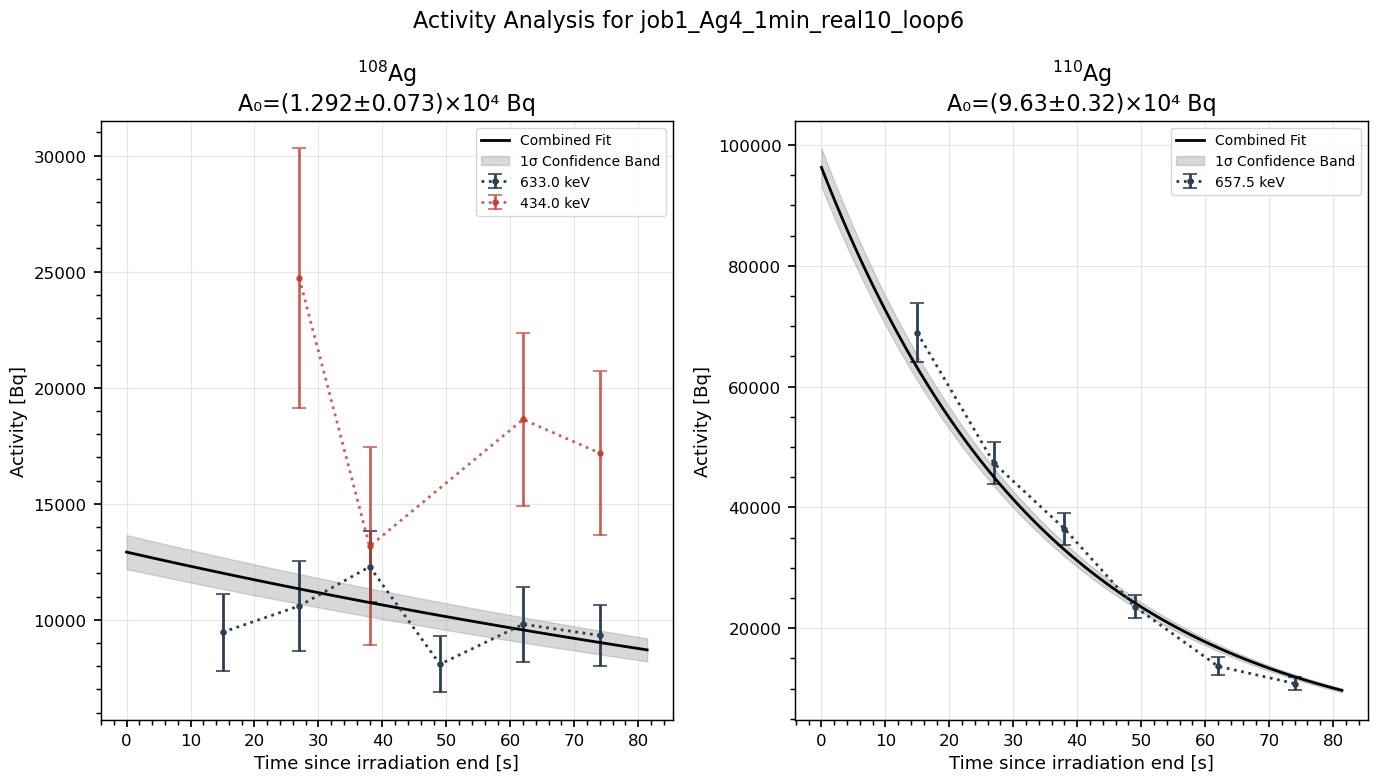

In [63]:
analysis_1.plot_activity()

### Job 2:
- Plate id: 10
- Irradiation time: 2 min
- Real time: 30s
- Num loops: 6

In [64]:
analysis_2 = SpectrumAnalysis(spec_exp_path / 'job2_Ag10_2min_real30_loop6', Δt_d=11)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_002.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_003.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_004.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_005.Spe


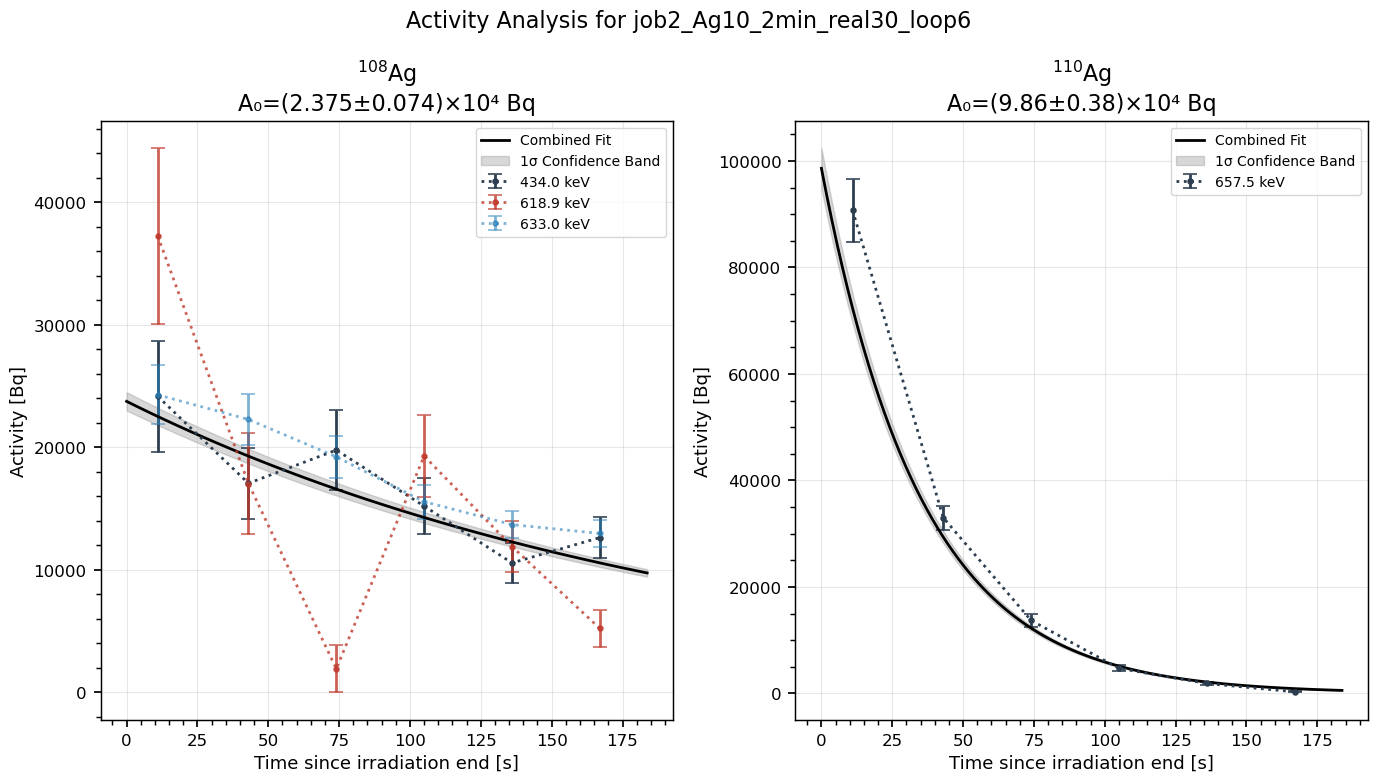

In [65]:
analysis_2.plot_activity()

### Job 3:
- Plate id: 73
- Irradiation time: 3 min
- Real time: 40s
- Num loops: 3

In [66]:
analysis_3 = SpectrumAnalysis(spec_exp_path / 'job3_Ag73_3min_real40_loop3', Δt_d=11)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_002.Spe


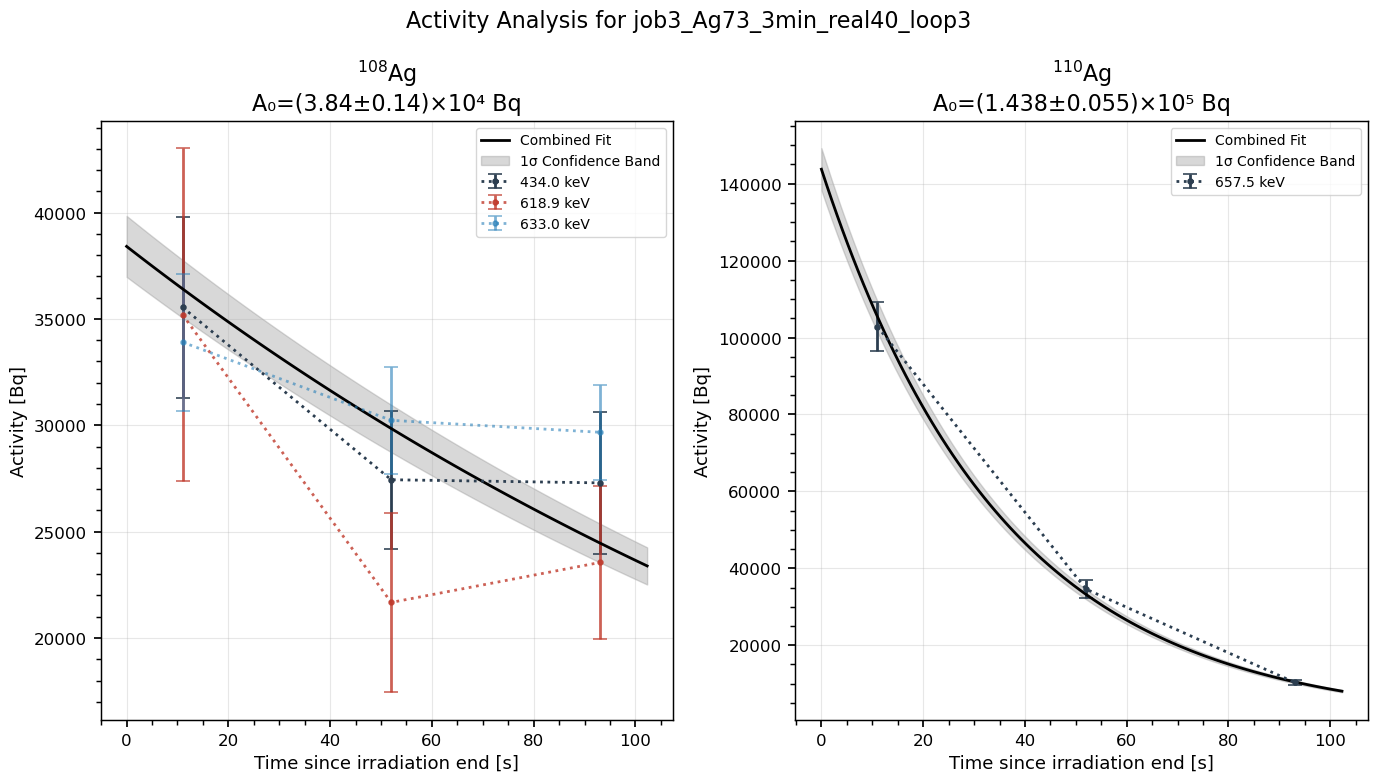

In [67]:
analysis_3.plot_activity()

### Job 4:
- Plate id: 2
- Irradiation time: 3 min
- Real time: 120s
- Num loops: 1

In [68]:
analysis_4 = SpectrumAnalysis(spec_exp_path / 'job4_Ag2_3min_real120_loop1', Δt_d=14)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job4_Ag2_3min_real120_loop1_000.Spe


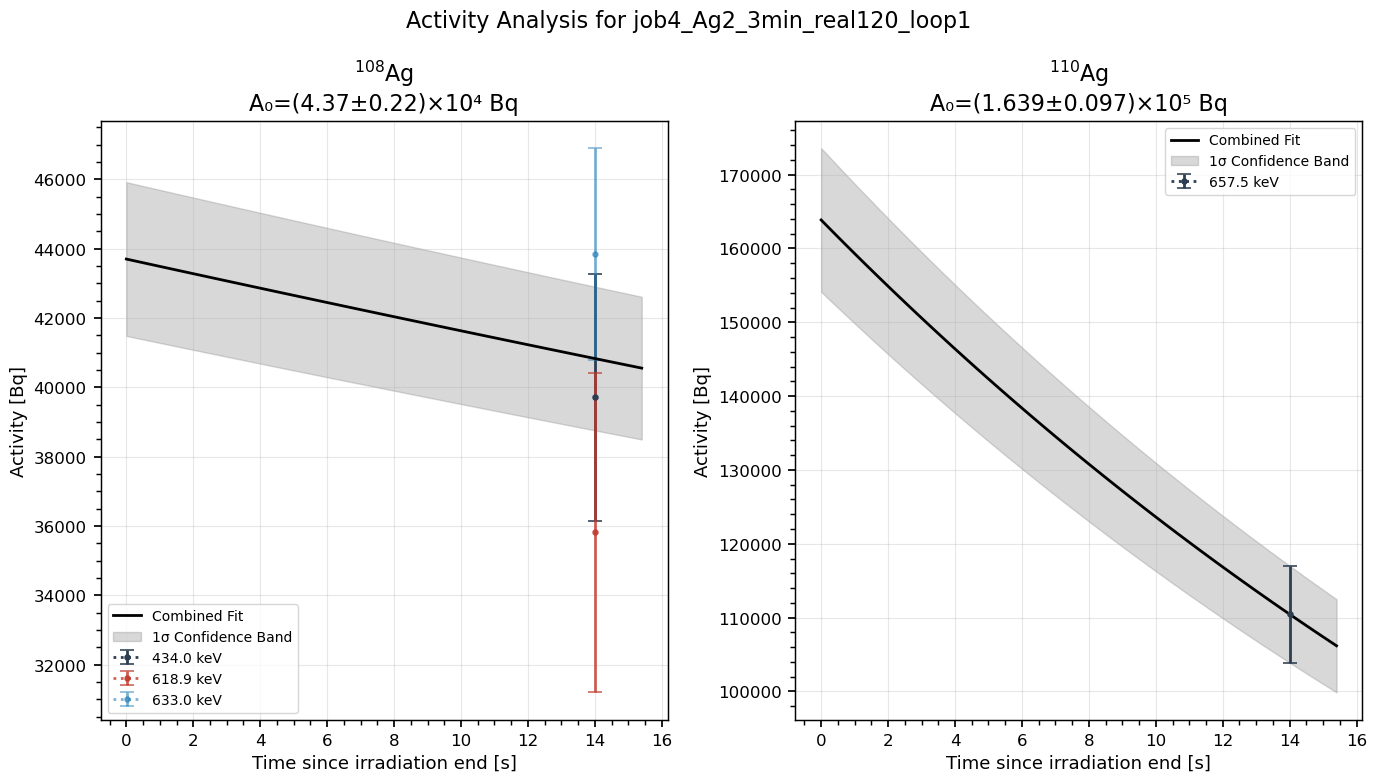

In [69]:
analysis_4.plot_activity()

### Job 5:
- Plate id: 4
- Irradiation time: 3 min
- Real time: 5s
- Num loops: 6

In [70]:
analysis_5 = SpectrumAnalysis(spec_exp_path / 'job5_Ag5_3min_real5_loop6', Δt_d=7)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_002.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_003.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_004.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_005.Spe


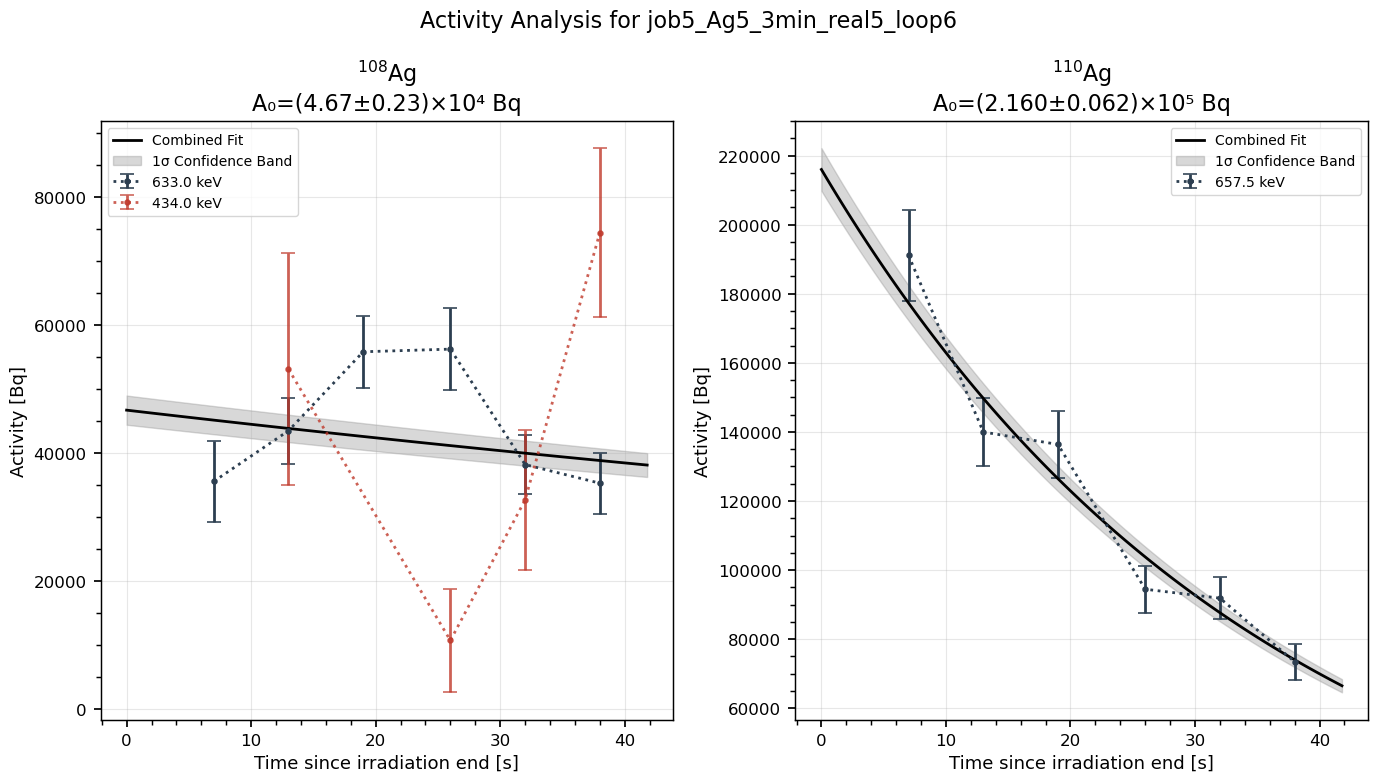

In [71]:
analysis_5.plot_activity()

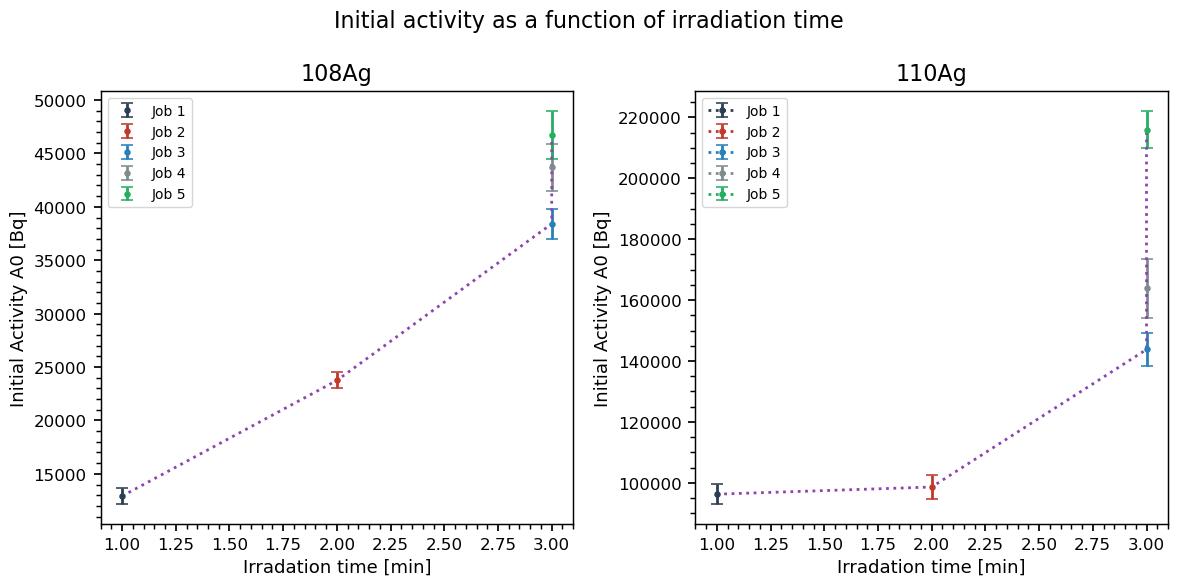

In [72]:
all_analyses = [analysis_1, analysis_2, analysis_3, analysis_4, analysis_5]
analysis_names = ['Job 1', 'Job 2', 'Job 3', 'Job 4', 'Job 5']
irradiation_times = [analysis.job_specs['irradiation_time'] for analysis in all_analyses]
A0_values_108 = [analysis.Ag108.A0.nominal_value for analysis in all_analyses]
A0_values_110 = [analysis.Ag110.A0.nominal_value for analysis in all_analyses]
A0_uncertainties_108 = [analysis.Ag108.A0.std_dev for analysis in all_analyses]
A0_uncertainties_110 = [analysis.Ag110.A0.std_dev for analysis in all_analyses] 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for irr, A0, A0_unc, job_number in zip(irradiation_times, A0_values_108, A0_uncertainties_108, analysis_names):
    plt.errorbar(irr, A0, yerr=A0_unc, fmt='o', label=job_number)
plt.plot(irradiation_times, A0_values_108, linestyle=':')

plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('108Ag')
plt.legend()

plt.subplot(1, 2, 2)
for irr, A0, A0_unc, job_number in zip(irradiation_times, A0_values_110, A0_uncertainties_110, analysis_names):
    plt.errorbar(irr, A0, yerr=A0_unc, marker='o', linestyle=':', label=job_number)
plt.plot(irradiation_times, A0_values_110, linestyle=':')
    
plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('110Ag')
plt.legend()

plt.suptitle('Initial activity as a function of irradiation time')
plt.tight_layout()
plt.savefig(fig_path / 'initial_activity_vs_irradiation_time.pdf')
plt.savefig(fig_path / 'initial_activity_vs_irradiation_time.png')
plt.show()

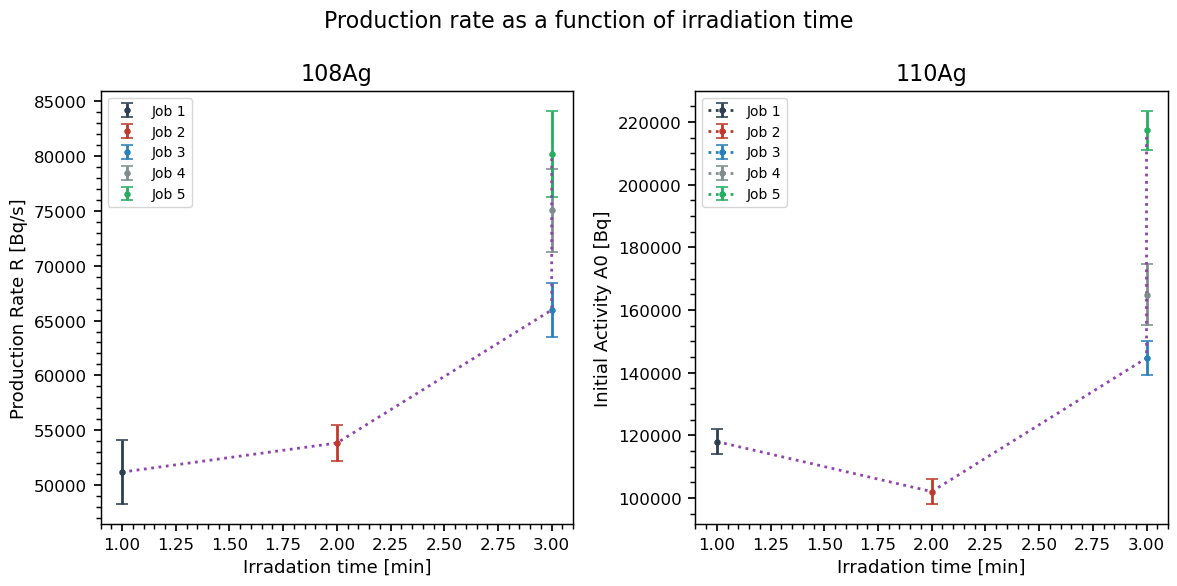

In [73]:
all_analyses = [analysis_1, analysis_2, analysis_3, analysis_4, analysis_5]
analysis_names = ['Job 1', 'Job 2', 'Job 3', 'Job 4', 'Job 5']
irradiation_times = [analysis.job_specs['irradiation_time'] for analysis in all_analyses]
A0_values_108 = [analysis.Ag108.A0.nominal_value for analysis in all_analyses]
A0_values_110 = [analysis.Ag110.A0.nominal_value for analysis in all_analyses]
A0_uncertainties_108 = [analysis.Ag108.A0.std_dev for analysis in all_analyses]
A0_uncertainties_110 = [analysis.Ag110.A0.std_dev for analysis in all_analyses] 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for irr, A0, A0_unc, job_number in zip(irradiation_times, A0_values_108, A0_uncertainties_108, analysis_names):
    λ = ci.Isotope('108AG').decay_const()
    R = A0 / (1 - np.exp(-λ * irr * 60))  # Convert minutes to seconds
    R_unc = A0_unc / (1 - np.exp(-λ * irr * 60))  # Uncertainty in production rate
    plt.errorbar(irr, R, yerr=R_unc, fmt='o', label=job_number)
plt.plot(irradiation_times, [A0 / (1 - np.exp(-λ * irr * 60)) for A0, irr in zip(A0_values_108, irradiation_times)], linestyle=':')

plt.xlabel('Irradation time [min]')
plt.ylabel('Production Rate R [Bq/s]')
plt.title('108Ag')
plt.legend()

plt.subplot(1, 2, 2)
for irr, A0, A0_unc, job_number in zip(irradiation_times, A0_values_110, A0_uncertainties_110, analysis_names):
    λ = ci.Isotope('110AG').decay_const()
    R = A0 / (1 - np.exp(-λ * irr * 60))  # Convert minutes to seconds
    R_unc = A0_unc / (1 - np.exp(-λ * irr * 60))  # Uncertainty in production rate
    plt.errorbar(irr, R, yerr=R_unc, marker='o', linestyle=':', label=job_number)
plt.plot(irradiation_times, [A0 / (1 - np.exp(-λ * irr * 60)) for A0, irr in zip(A0_values_110, irradiation_times)], linestyle=':')

plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('110Ag')
plt.legend()

plt.suptitle('Production rate as a function of irradiation time')
plt.tight_layout()
plt.savefig(fig_path / 'production_rate_vs_irradiation_time.pdf')
plt.savefig(fig_path / 'production_rate_vs_irradiation_time.png')
plt.show()

# Part 2: Cross Sections

## Utility Functions

In [74]:
# def get_isotope(Z: int , N: int) -> ci.Isotope:
#     """
#     Returns the isotope with atomic number Z and neutron number N.
    
#     Parameters
#     ----------
#     Z : int
#         Atomic number of the isotope.
#     N : int
#         Neutron number of the isotope.
        
#     Returns
#     -------
#     ci.Isotope
#         The isotope object corresponding to the given Z and N.
#     """
#     A = Z + N
#     element = pt.elements[Z].symbol.upper() 
#     iso_name = f'{A}{element}'
#     return ci.Isotope(iso_name)
    
# def get_products(target: str|list[str], particle_beam: Literal['proton', 'neutron', 'deuteron'] = 'proton', n_alpha: int = 3) -> tuple[ci.Isotope]:
#         """
#         Creates a list of all isotopes produced by a particle beam on a target material. Material is assumed to be in natural abundance.
        
#         Parameters
#         ----------
#         target : str|list[str]
#             The target material, e.g., 'Ag'/'AG', 'Au'/'AU', 'Cu'/'CU'. All naturally occuring isotopes will be used. If a list is provided, it should contain isotopes in the form of strings like '69GA', '71GA'.
#         particle_beam : Literal['proton', 'neutron', 'deuteron'], optional
#             The type of particle beam used, e.g., 'proton', 'neutron' or 'deuteron'. Defaults to 'proton'.
#         n_alpha : int, optional
#             The span of decays to consider. Defaults to 3.
            
#         Returns
#         -------
#         tuple[ci.Isotope]
#             A tuple of isotopes produced by the particle beam on the target material.
            
#         Raises
#         ------
#         ValueError
#             If an unsupported particle beam type is provided.
#         TypeError
#             If the target is not a string or a list of strings.
#         """
#         if particle_beam == 'proton':
#             Z_add, N_add = 1, 0  # Proton beam adds 1 proton
#         elif particle_beam == 'neutron':
#             Z_add, N_add = 0, 1  # Neutron beam adds 1 neutron
#         elif particle_beam == 'deuteron':
#             Z_add, N_add = 1, 1
#         else:
#             raise ValueError(f"Unsupported particle beam type: {particle_beam}. Use 'proton', 'neutron', or 'deuteron'.")
        
        
#         isotopes = None
#         if isinstance(target, str):
#             element = ci.Element(target)
#             isotopes: pd.DataFrame     = element.abundances # Naturally occurring isotopes
#             isotopes: list[ci.Isotope] = [ci.Isotope(iso.upper()) for iso in isotopes['isotope']]
            
#         elif isinstance(target, list):
#             # Assume target is a list of isotope strings like ['69GA', '71GA']
#             isotopes = [ci.Isotope(iso.upper()) for iso in target]
        
#         else:
#             raise TypeError(f"Target must be a string representing an element or a list of isotope strings, got {type(target)}.")
            
#         isotopes: list[ci.Isotope] = sorted(isotopes, key=lambda iso: iso.A, reverse=True) # Sort by mass number A in descending order
        
#         products = []
#         product_names = set()  # To avoid duplicates 
#         for iso in isotopes:
#             Z, N = iso.Z, iso.N
#             Z_prod = Z + Z_add
#             N_prod = N + N_add
#             direct_product = get_isotope(Z_prod, N_prod)
#             if direct_product._short_name not in product_names:
#                 products.append(direct_product)
#                 product_names.add(direct_product._short_name)
#             # Create new product isotopes by adding protons or neutrons
#             for Z in range(Z_prod, Z_prod-2*n_alpha -1, -1): # Starting on the product isotope and going left
#                 for N in range(N_prod, N_prod-2*n_alpha -1, -1): # Starting on the product isotope and going down
#                     product = get_isotope(Z, N)
#                     if product._short_name not in product_names:
#                         products.append(product)
#                         product_names.add(product._short_name)
        
#         return tuple(products)
    
# def find_interesting_products(isotopes: Iterable, max_half_life: float = 100, min_half_life: float = 60, uncertain_half_life = 10) -> tuple[list[ci.Isotope], list[ci.Isotope]]:
#     """
#     Filters isotopes based on their half-life.

#     Parameters
#     ----------
#     isotopes : Iterable
#         An iterable of `ci.Isotope` objects to filter.
#     max_half_life : float, optional
#         Maximum half-life in years. Defaults to 100.
#     min_half_life : float, optional
#         Minimum half-life in seconds. Defaults to 60.
#     uncertain_half_life : float, optional
#         Half-life in minutes to consider isotopes that might be interesting. Defaults to 10.
        
#     Returns
#     -------
#     tuple[list[ci.Isotope], list[ci.Isotope]]
#         A tuple containing two lists:
#         - `observed_isotopes`: Isotopes with a half-life between `uncertain_half_life` and `max_half_life`.
#         - `potentially_observed_isotopes`: Isotopes with a half-life between `min_half_life` and `uncertain_half_life`.
#     """
#     observed_isotopes = []
#     potentially_observed_isotopes = []
    
#     for iso in isotopes:
#         if uncertain_half_life*60 < iso.half_life() < max_half_life*365*24*3600:
#             observed_isotopes.append(iso)
#         elif min_half_life < iso.half_life() < uncertain_half_life*60:
#             potentially_observed_isotopes.append(iso)
#     return observed_isotopes, potentially_observed_isotopes

# def sort_isotopes(isotopes: Iterable) -> list[ci.Isotope]:
#     """
#     Sorts a list of isotopes by their number of neutrons and protons in descending order.
#     Parameters
#     ----------
#     isotopes : Iterable
#         An iterable of `ci.Isotope` objects to sort.
#     Returns
#     -------
#     list[ci.Isotope]
#         A sorted list of isotopes.
#     """
#     return sorted(isotopes, key=lambda iso: (iso.Z, iso.N), reverse=True)

# # TODO: Not needed with dataframes
# def create_markdown_table(observed_isotopes: list[ci.Isotope], potentially_observed_isotopes: list[ci.Isotope]) -> str:
#     """
#     Creates a Markdown table for observed and potentially observed isotopes.

#     Parameters
#     ----------
#     observed_isotopes : list[ci.Isotope]
#         List of observed isotopes.
#     potentially_observed_isotopes : list[ci.Isotope]
#         List of potentially observed isotopes.

#     Returns
#     -------
#     str
#         A Markdown formatted string representing the table.
#     """
    
#     isotopes = sort_isotopes(observed_isotopes + potentially_observed_isotopes)
    
#     markdown_table = "| Isotope | Half-life  | Observed | Maybe Observed |\n"
#     markdown_table += "|---------|------------|----------|----------------|\n"
    
#     for iso in isotopes:
#         unit = iso.optimum_units()
#         half_life = iso.half_life(units=unit)
        
#         if iso in observed_isotopes:
#             observed = '[x]'
#             maybe_observed = '[ ]'
            
#         elif iso in potentially_observed_isotopes:
#             observed = '[ ]'
#             maybe_observed = '[x]'
            
#         markdown_table += f"| {iso._short_name:<7} | {f'{half_life:.2f} {unit}':<10} | {observed:<8} | {maybe_observed:<14} |\n"
    
#     pyperclip.copy(markdown_table)  # Copy the table to clipboard
#     print("Markdown table copied to clipboard.")
#     return markdown_table

# # TODO: Not needed with dataframes
# def create_complete_markdown_table(isotopes: Iterable[ci.Isotope], 
#                                   max_half_life: float = 100, 
#                                   min_half_life: float = 60, 
#                                   uncertain_half_life: float = 10) -> str:
#     """
#     Creates a complete Markdown table for isotopes with their half-lives and observation status.

#     Parameters
#     ----------
#     isotopes : Iterable[ci.Isotope]
#         An iterable of `ci.Isotope` objects to include in the table.
#     max_half_life : float, optional
#         Maximum half-life in years. Defaults to 100.
#     min_half_life : float, optional
#         Minimum half-life in seconds. Defaults to 60.
#     uncertain_half_life : float, optional
#         Half-life in minutes to consider isotopes that might be interesting. Defaults to 10.

#     Returns
#     -------
#     str
#         A Markdown formatted string representing the complete table.
#     """
    
#     isotopes = sort_isotopes(isotopes)
#     markdown_table = "| Isotope | Half-life  | Observed | Not Observed | Maybe Observed |\n"
#     markdown_table += "|---------|------------|----------|--------------|----------------|\n"
    
#     for iso in isotopes:
#         hf = iso.half_life()
        
#         if hf > max_half_life * 365 * 24 * 3600:
#             observed = '[ ]'
#             not_observed = '[x]'
#             maybe_observed = '[ ]'
#         elif hf < min_half_life:
#             observed = '[ ]'
#             not_observed = '[x]'
#             maybe_observed = '[ ]'
#         elif min_half_life <= hf < uncertain_half_life * 60:
#             observed = '[ ]'
#             not_observed = '[ ]'
#             maybe_observed = '[x]'
#         else:
#             observed = '[x]'
#             not_observed = '[ ]'
#             maybe_observed = '[ ]'
            
#         unit = iso.optimum_units()
#         hf = iso.half_life(units=unit)
#         hf_formatted = f'{hf:.2g} {unit}' if hf != np.inf else 'Stable'
        
        
#         markdown_table += f"| {iso._short_name:<7} | {hf_formatted:<10} | {observed:<8} | {not_observed:<12} | {maybe_observed:<14} |\n"
    
#     pyperclip.copy(markdown_table)  # Copy the table to clipboard
#     print("Markdown table copied to clipboard.")
#     return markdown_table

# def format_dataframe_with_checkboxes(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Formats a DataFrame to replace boolean values with checkboxes.

#     Parameters
#     ----------
#     df : pd.DataFrame
#         The DataFrame to format.

#     Returns
#     -------
#     pd.DataFrame
#         A formatted DataFrame with checkboxes instead of boolean values.
#     """
#     formatted_df = df.copy()
#     for col in ["Observed", "Not Observed", "Maybe Observed"]:
#         formatted_df[col] = formatted_df[col].apply(lambda x: "✔" if x else "✘")
#     return formatted_df

# def create_complete_isotope_dataframe(isotopes: Iterable[ci.Isotope], 
#                              max_half_life: float = 100, 
#                              min_half_life: float = 60, 
#                              uncertain_half_life: float = 10) -> pd.DataFrame:
#     """
#     Creates a DataFrame for isotopes with their half-lives and observation status.

#     Parameters
#     ----------
#     isotopes : Iterable[ci.Isotope]
#         An iterable of `ci.Isotope` objects to include in the table.
#     max_half_life : float, optional
#         Maximum half-life in years. Defaults to 100.
#     min_half_life : float, optional
#         Minimum half-life in seconds. Defaults to 60.
#     uncertain_half_life : float, optional
#         Half-life in minutes to consider isotopes that might be interesting. Defaults to 10.

#     Returns
#     -------
#     pd.DataFrame
#         A DataFrame containing isotope information with columns for half-life and observation status.
#     """
#     isotopes = sort_isotopes(isotopes)
#     data = []

#     for iso in isotopes:
#         hf = iso.half_life()
        
#         if hf > max_half_life * 365 * 24 * 3600:
#             observed = False
#             not_observed = True
#             maybe_observed = False
#         elif hf < min_half_life:
#             observed = False
#             not_observed = True
#             maybe_observed = False
#         elif min_half_life <= hf < uncertain_half_life * 60:
#             observed = False
#             not_observed = False
#             maybe_observed = True
#         else:
#             observed = True
#             not_observed = False
#             maybe_observed = False
            
#         unit = iso.optimum_units()
#         hf = iso.half_life(units=unit)
#         hf_formatted = f'{hf:.2g} {unit}' if hf != np.inf else 'Stable'
        
#         data.append({
#             "Isotope": iso._short_name,
#             "Half-life": hf_formatted,
#             "Observed": observed,
#             "Not Observed": not_observed,
#             "Maybe Observed": maybe_observed
#         })

#     df = pd.DataFrame(data)
#     return df

# def name_trans_curie_tendl(name: str) -> str:
#     """
#     Converts isotope names from the format '108AG' to 'Ag108'.
#     """ 
#     numbers_part = ''.join(filter(str.isdigit, name))
#     letters_part = ''.join(filter(str.isalpha, name)).capitalize()
#     return f"{letters_part}{numbers_part}"

# def name_trans_tendl_curie(name: str) -> str:
#     """
#     Converts isotope names from the format 'Ag108' to '108AG'.
#     """
#     numbers_part = ''.join(filter(str.isdigit, name))
#     letters_part = ''.join(filter(str.isalpha, name)).upper()
#     return f"{numbers_part}{letters_part}"

In [75]:
class CrossSectionAnalysis:
    """
    Class to analyze cross-section data for isotopes.
    """ 
    def __init__(self, 
                 target: str|list[str], 
                 particle_beam: Literal['proton', 'neutron', 'deuteron'] = 'proton', 
                 n_alpha: int = 3, 
                 max_half_life: float = 100, 
                 min_half_life: float = 60, 
                 grayzone_half_life: float = 10
                 ) -> None:
        """
        Initializes the CrossSectionAnalysis class.

        Parameters
        ----------
        target : str|list[str]
            The target material, e.g., 'Ag'/'AG', 'Au'/'AU', 'Cu'/'CU'. All naturally occurring isotopes will be used. If a list is provided, it should contain isotopes in the form of strings like '69GA', '71GA'.
        particle_beam : Literal['proton', 'neutron', 'deuteron'], optional
            The type of particle beam used, e.g., 'proton', 'neutron' or 'deuteron'. Defaults to 'proton'.
        n_alpha : int, optional
            The span of decays to consider. Defaults to 3.
        max_half_life : float, optional
            Maximum half-life in years. Defaults to 100.
        min_half_life : float, optional
            Minimum half-life in seconds. Defaults to 60.
        grayzone_half_life : float, optional
            Half-life in minutes to consider isotopes that might be interesting. Defaults to 10.
        """
        
        self.target = target
        self.particle_beam = particle_beam
        self.n_alpha = n_alpha
        
        self.max_half_life = max_half_life
        self.min_half_life = min_half_life
        self.grayzone_half_life = grayzone_half_life
        
        # Get all products from the target material and particle beam
        self.products = self._get_products(target, particle_beam, n_alpha)
        
        # Filter products based on half-life criteria
        self.observed_isotopes, self.grayzone_isotopes = self._filter_products_halflife(self.products, max_half_life=max_half_life, min_half_life=min_half_life, grayzone_half_life=grayzone_half_life
        )
        
        # Create Tendl objects for cross-section data
        self.tendl = Tendl(self._target_abundance(), self.particle_beam)
        
        
    # TODO: Maybe make a single row for "observed", then add "✔", "✘" or "~" for each possible state
    def isotope_overview(self, isotopes: list[str] = None, max_half_life = None, min_half_life = None, grayzone_half_life = None, copy_to_clipboard: bool = False, print_markdown = False) -> pd.DataFrame:
        """
        Creates an overview of isotopes with their half-lives and observation status.

        Parameters
        ----------
        isotopes : list[str], optional
            A list of isotope names to include in the overview. If `None`, uses all products found from the target and particle beam upon initialization.
        max_half_life : float, optional
            Maximum half-life in years. Defaults to the class attribute `max_half_life`.
        min_half_life : float, optional
            Minimum half-life in seconds. Defaults to the class attribute `min_half_life`.
        grayzone_half_life : float, optional
            Half-life in minutes to consider isotopes that might be interesting. Defaults to the class attribute `grayzone_half_life`.
        copy_to_clipboard : bool, optional
            If `True`, copies a markdown table created from the dataframe to the clipboard. Defaults to `False`.  
        print_markdown : bool, optional
            If `True`, prints the markdown table to the console. Defaults to `False`.
        
        Returns
        -------
        pd.DataFrame
            A DataFrame containing isotope information with columns for half-life and observation status.
        """
        if isotopes is None:
            isotopes = self.products
        else:
            isotopes = [iso.upper() for iso in isotopes]  # Ensure isotopes are in uppercase
            
        if max_half_life is None:
            max_half_life = self.max_half_life
            
        if min_half_life is None:
            min_half_life = self.min_half_life
            
        if grayzone_half_life is None:
            grayzone_half_life = self.grayzone_half_life
        
        # Temporarily convert names to Isotope objects for filtering
        isotopes = [ci.Isotope(name.upper()) for name in isotopes]
        isotopes = sorted(isotopes, key=lambda iso: (iso.Z, iso.N), reverse=True) # Sort by Z and N in descending order
        isotopes = [iso._short_name for iso in isotopes] 
        
        # If no new filters are applied, use the already filtered lists to avoid unnecessary printing and processing
        if max_half_life == self.max_half_life and min_half_life == self.min_half_life and grayzone_half_life == self.grayzone_half_life:
            observed_isotopes, grayzone_isotopes = self.observed_isotopes, self.grayzone_isotopes
        else:
            observed_isotopes, grayzone_isotopes = self._filter_products_halflife(isotopes, max_half_life=max_half_life, min_half_life=min_half_life, grayzone_half_life=grayzone_half_life)
        
        data = []
        for iso_name in isotopes:
            if iso_name in observed_isotopes:
                observed = True
                not_observed = False
                maybe_observed = False
            elif iso_name in grayzone_isotopes:
                observed = False
                not_observed = False
                maybe_observed = True
            else:
                observed = False
                not_observed = True
                maybe_observed = False
            
            iso = ci.Isotope(iso_name.upper())
            unit = iso.optimum_units()
            hf = iso.half_life(units=unit)
            hf_formatted = f'{hf:.2g} {unit}' if hf != np.inf else 'Stable'
            
            data.append({
                "Isotope": iso_name.title(),
                "Half-life": hf_formatted,
                "Observed": observed,
                "Not Observed": not_observed,
                "Maybe Observed": maybe_observed
            })
        
        df = pd.DataFrame(data)
        formatted_df = self._format_dataframe_with_checkboxes(df)
        
        if copy_to_clipboard:
            markdown_table = formatted_df.to_markdown(index=False)
            pyperclip.copy(markdown_table)
            print("\nMarkdown table copied to clipboard.")
        if print_markdown:
            markdown_table = formatted_df.to_markdown(index=False)
            print(markdown_table)
        
        return df
    
    def save_tendl_data(self, path: Path, isotopes: list[str] = None, Elimit: float = 60, silent = False) -> None:
        """
        Saves Tendl cross-section data for specified isotopes to a .npy file.
        
        Parameters
        ----------
        path : Path
            The path where the data will be saved.
        isotopes : list[str], optional
            A list of isotope names to save. e.g., ['Ag108', 'Ag110']. If `None`, saves all products found from the target and particle beam upon initialization.
        Elimit : float, optional
            The energy limit for the cross-section data. Defaults to 60 MeV.
        silent : bool, optional
            If `True`, suppresses print statements. Defaults to `False`.
        """
        if isotopes is None:
            isotopes = self.products
        
        if not path.exists():
            path.mkdir(parents=True, exist_ok=True)
        
        for iso_name in isotopes:
            iso = ci.Isotope(iso_name.upper())
            Z, A = str(iso.Z), str(iso.A)
            E, Cs = self.tendl.tendlData(Z, A, Elimit=Elimit)
            if E is None or Cs is None:
                if not silent:
                    print(f"No cross-section data found for {iso_name}. Skipping.")
                continue
            else:
                np.save(path / f'{iso_name.title()}.npy', np.array([E, Cs]))
    
    def load_tendl_data(self, path: Path, isotopes: list[str] = None) -> dict[str, tuple[np.ndarray, np.ndarray]]:
        """
        Loads Tendl cross-section data from .npy files in the specified directory for given isotopes.
        
        Parameters
        ----------
        path : Path
            The path where the data is stored.
        isotopes : list[str], optional
            A list of isotope names to load. e.g., ['Ag108', 'Ag110']. If `None`, loads all products found from the target and particle beam upon initialization.
            
        Returns
        -------
        dict[str, tuple[np.ndarray, np.ndarray]]
            A dictionary where keys are isotope names and values are tuples of numpy arrays (energies, cross-sections).
        """
        if isotopes is None:
            isotopes = self.products
        
        if not path.exists():
            raise FileNotFoundError(f"The directory {path} does not exist.")
        
        data = {iso.upper(): self._load_npy(path / f'{iso.title()}.npy') for iso in isotopes}
        self.loaded_data = data
        
        return data
    
    def plot_filtered_Cs(self, title: str, isotopes: dict[str, tuple[np.ndarray, np.ndarray]]|list[str] = None, Cs_threshold: float = 1e-2, low_Cs_threshold: float = 10, Elimit: float = 60) -> plt.Figure:
        """
        Plots cross-section data for isotopes with cross-sections above a specified threshold.
        
        Parameters
        ----------
        title : str
            The title of the plot.
        isotopes : dict[str, tuple[np.ndarray, np.ndarray]] | list[str], optional
            A dictionary where keys are isotope names and values are tuples of numpy arrays (energies, cross-sections). If a list is provided, it should contain isotope names as strings. If `None`, uses the loaded data from `load_tendl_data`.
        Cs_threshold : float, optional
            The threshold for cross-sections to be plotted. Defaults to 1e-2.
        low_Cs_threshold : float, optional
            The threshold for a cross-section to be considered low. Defaults to 10.
        Elimit : float, optional
            The energy limit for the cross-section data. Defaults to 60 MeV.
        """
        
        # Check if isotopes is None, if so, use loaded data
        data = {}
        if isotopes is None:      
            if not hasattr(self, 'loaded_data'):
                raise ValueError("No loaded data found. Please load data using `load_tendl_data()` method before plotting or provide isotopes.")   
               
            for iso_name, (E, Cs) in self.loaded_data.items():
                if iso_name in self.observed_isotopes:
                    data[iso_name] = (E, Cs)
        
        elif isinstance(isotopes, dict):
            data.update(isotopes)  # Use the provided dictionary directly
        
        # If isotopes is a list of strings, convert to Isotope objects
        elif all(isinstance(iso, str) for iso in isotopes):
            for iso in isotopes:
                iso = ci.Isotope(iso.upper())
                Z, A = str(iso.Z), str(iso.A)
                E, Cs = self.tendl.tendlData(Z, A, Elimit=Elimit)
                if E is not None and Cs is not None:
                    data[iso._short_name] = (E, Cs)
        
        # If isotopes is a list of Isotope objects, convert to dictionary
        elif all(isinstance(iso, ci.Isotope) for iso in isotopes):
            for iso in isotopes:
                Z, A = str(iso.Z), str(iso.A)
                E, Cs = self.tendl.tendlData(Z, A, Elimit=Elimit)
                if E is not None and Cs is not None:
                    data[iso._short_name] = (E, Cs)                    

        else:
            raise TypeError(f"Invalid type for isotopes: {type(isotopes)}. Expected list of strings, list of Isotope objects, or dictionary.")
                    
                    
        # Filter isotopes based on cross-section threshold
        filtered_isotopes = {}
        for i, (iso_name, (E, Cs)) in enumerate(data.items()):
            max_Cs = np.max(Cs)
            if max_Cs > Cs_threshold:
                filtered_isotopes.update({iso_name: (E, Cs)})
                
        # Sort isotopes by maximum cross-section value in descending order
        sorted_filtered_isotopes = sorted(filtered_isotopes.items(), key=lambda item: np.max(item[1][1]), reverse=True)
        self.filtered_isotopes = sorted_filtered_isotopes  # Store filtered isotopes for further use
        
        
        
        # Plot the filtered isotopes
        colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_filtered_isotopes)))
        linestyles = ['-', '--', '-.']
        for i, (iso_name, (E, Cs)) in enumerate(sorted_filtered_isotopes):
            max_Cs = np.max(Cs)
            if max_Cs > low_Cs_threshold:
                label = f"{ci.Isotope(iso_name.upper()).TeX}"
                linestyle = linestyles[i % len(linestyles)]
            else:
                label = fr"{ci.Isotope(iso_name.upper()).TeX}$^{'*'}$"
                linestyle = ':'
            
            plt.plot(E, Cs, label=label, color=colors[i % len(colors)], linestyle=linestyle)
        
        plt.xlabel('Energy (MeV)')
        plt.ylabel('Cross-section (mb)')
        plt.suptitle(title, y=0.95)
        plt.title(f'Isotopes marked with * have a maximum cross-section below {low_Cs_threshold} mb.', fontsize=10)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        
        print(f'Found {len(sorted_filtered_isotopes)}/{len(data)} isotopes with cross-sections above {Cs_threshold} mb:')
        print(' '.join([iso for iso, _ in sorted_filtered_isotopes]))
        
        
        return plt.gcf()  # Return the current figure for further manipulation or saving
    
    def filter_products_Cs(self, isotopes: list[str] = None, Cs_threshold: float = 1e-2, Elimit: float = 60) -> dict[str, tuple[np.ndarray, np.ndarray]]:
        """
        Filters isotopes based on cross-section data above a specified threshold.
        """
        
        data = {}
        if isotopes is None:
            isotopes = self.products
            if not hasattr(self, 'loaded_data'):
                raise ValueError("No loaded data found. Please load data using `load_tendl_data()` method before plotting or provide isotopes.")   
            
            for iso_name, (E, Cs) in self.loaded_data.items():
                if iso_name in self.observed_isotopes:
                    data[iso_name] = (E, Cs)
        
        elif isinstance(isotopes, dict):
            data.update(isotopes)  # Use the provided dictionary directly
        
        # If isotopes is a list of strings, convert to Isotope objects
        elif all(isinstance(iso, str) for iso in isotopes):
            for iso in isotopes:
                iso = ci.Isotope(iso.upper())
                Z, A = str(iso.Z), str(iso.A)
                E, Cs = self.tendl.tendlData(Z, A, Elimit=Elimit)
                if E is not None and Cs is not None:
                    data[iso._short_name] = (E, Cs)
        
        # If isotopes is a list of Isotope objects, convert to dictionary
        elif all(isinstance(iso, ci.Isotope) for iso in isotopes):
            for iso in isotopes:
                Z, A = str(iso.Z), str(iso.A)
                E, Cs = self.tendl.tendlData(Z, A, Elimit=Elimit)
                if E is not None and Cs is not None:
                    data[iso._short_name] = (E, Cs)                    

        else:
            raise TypeError(f"Invalid type for isotopes: {type(isotopes)}. Expected list of strings, list of Isotope objects, or dictionary.")
        
        # Filter isotopes based on cross-section threshold
        filtered_isotopes = {}
        for i, (iso_name, (E, Cs)) in enumerate(data.items()):
            max_Cs = np.max(Cs)
            if max_Cs > Cs_threshold:
                filtered_isotopes.update({iso_name: (E, Cs)})
        
        # Sort isotopes by maximum cross-section value in descending order
        sorted_filtered_isotopes = sorted(filtered_isotopes.items(), key=lambda item: np.max(item[1][1]), reverse=True)
        
        return sorted_filtered_isotopes 
        
    def _get_isotope(self, Z: int, N: int) -> ci.Isotope:
        """
        Returns the isotope with atomic number Z and neutron number N.
        
        Parameters
        ----------
        Z : int
            Atomic number of the isotope.
        N : int
            Neutron number of the isotope.
            
        Returns
        -------
        ci.Isotope
            The isotope object corresponding to the given Z and N.
        """
        A = Z + N
        element = pt.elements[Z].symbol.upper() 
        iso_name = f'{A}{element}'
        return ci.Isotope(iso_name)
        
    def _get_products(self, target: str|list[str], particle_beam: Literal['proton', 'neutron', 'deuteron'] = 'proton', n_alpha: int = 3) -> tuple[str]:
        """
        Creates a list of all isotopes produced by a particle beam on a target material. Material is assumed to be in natural abundance.
        
        Parameters
        ----------
        target : str|list[str]
            The target material, e.g., 'Ag'/'AG', 'Au'/'AU', 'Cu'/'CU'. All naturally occurring isotopes will be used. If a list is provided, it should contain isotopes in the form of strings like '69GA', '71GA'.
        particle_beam : Literal['proton', 'neutron', 'deuteron'], optional
            The type of particle beam used, e.g., 'proton', 'neutron' or 'deuteron'. Defaults to 'proton'.
        n_alpha : int, optional
            The span of decays to consider. Defaults to 3.
            
        Returns
        -------
        tuple[ci.Isotope]
            A tuple of isotopes produced by the particle beam on the target material.
            
        Raises
        ------
        ValueError
            If an unsupported particle beam type is provided.
        TypeError
            If the target is not a string or a list of strings.
        """
        
        if particle_beam == 'proton':
            Z_add, N_add = 1, 0  # Proton beam adds 1 proton
        elif particle_beam == 'neutron':
            Z_add, N_add = 0, 1  # Neutron beam adds 1 neutron
        elif particle_beam == 'deuteron':
            Z_add, N_add = 1, 1
        else:
            raise ValueError(f"Unsupported particle beam type: {particle_beam}. Use 'proton', 'neutron', or 'deuteron'.")   
        
        isotopes = None
        if isinstance(target, str):
            element = ci.Element(target)
            isotopes: pd.DataFrame     = element.abundances # Naturally occurring isotopes
            isotopes: list[ci.Isotope] = [ci.Isotope(iso.upper()) for iso in isotopes['isotope']]   
            
        elif isinstance(target, list):
            isotopes = [ci.Isotope(iso.upper()) for iso in target]
            
        else:
            raise TypeError(f"Target must be a string representing an element or a list of isotope strings, got {type(target)}.")
        
        isotopes: list[ci.Isotope] = sorted(isotopes, key=lambda iso: iso.A, reverse=True) # Sort by mass number A in descending order
        
        products = []
        product_names = set()  # To avoid duplicates
        for iso in isotopes:
            Z, N = iso.Z, iso.N
            Z_prod = Z + Z_add
            N_prod = N + N_add
            direct_product = self._get_isotope(Z_prod, N_prod)
            if direct_product._short_name not in product_names:
                products.append(direct_product)
                product_names.add(direct_product._short_name)
            # Create new product isotopes by adding protons or neutrons
            for Z in range(Z_prod, Z_prod-2*n_alpha -1, -1):
                for N in range(N_prod, N_prod-2*n_alpha -1, -1):
                    product = self._get_isotope(Z, N)
                    if product._short_name not in product_names:
                        products.append(product)
                        product_names.add(product._short_name)
                        
        return tuple(product_names)
          
    def _filter_products_halflife(self, isotopes: list[str] = None, max_half_life = None, min_half_life = None, grayzone_half_life = None) -> tuple[list[ci.Isotope], list[ci.Isotope]]:
        """
        Filters isotopes based on their half-life. Adds the results to the class attributes `observed_isotopes` and `grayzone_isotopes`.

        Parameters
        ----------
        isotopes : list[str], optional
            A list of isotope names to filter. If `None`, uses all products found from the target and particle beam upon initialization.
        max_half_life : float, optional
            Maximum half-life in years. Defaults to the class attribute `max_half_life`.
        min_half_life : float, optional
            Minimum half-life in seconds. Defaults to the class attribute `min_half_life`.
        grayzone_half_life : float, optional
            Half-life in minutes to consider isotopes that might be interesting. Defaults to the class attribute `grayzone_half_life`.

        Returns
        -------
        tuple[list[ci.Isotope], list[ci.Isotope]]
            A tuple containing two lists:
            - `observed_isotopes`: Isotopes with a half-life between `grayzone_half_life` and `max_half_life`.
            - `potentially_observed_isotopes`: Isotopes with a half-life between `min_half_life` and `grayzone_half_life`.
        """
        
        if isotopes is None:
            isotopes = self.products
            
        if max_half_life is None:
            max_half_life = self.max_half_life
            
        if min_half_life is None:
            min_half_life = self.min_half_life
            
        if grayzone_half_life is None:
            grayzone_half_life = self.grayzone_half_life
            
        observed_isotopes = []
        potentially_observed_isotopes = []
        
        for iso_name in isotopes:
            iso = ci.Isotope(iso_name.upper())
            if grayzone_half_life*60 < iso.half_life() < max_half_life*365*24*3600:
                observed_isotopes.append(iso._short_name)
            elif min_half_life < iso.half_life() < grayzone_half_life*60:
                potentially_observed_isotopes.append(iso._short_name)
        
        self.observed_isotopes = observed_isotopes
        self.grayzone_isotopes = potentially_observed_isotopes
        
        print(f"Found {len(observed_isotopes)}/{len(isotopes)} isotopes to be observed based on half-life:")
        print(' '.join(list(map(str.title, observed_isotopes))))
        
        print()
        
        print(f"Found {len(potentially_observed_isotopes)}/{len(isotopes)} isotopes which might be observed based on half-life.")
        print(' '.join(list(map(str.title, potentially_observed_isotopes))))
        
        return observed_isotopes, potentially_observed_isotopes

    def _format_dataframe_with_checkboxes(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Formats a DataFrame to replace boolean values with checkboxes.
    
        Parameters
        ----------
        df : pd.DataFrame
            The DataFrame to format.
    
        Returns
        -------
        pd.DataFrame
            A formatted DataFrame with checkboxes instead of boolean values.
        """
        formatted_df = df.copy()
        for col in ["Observed", "Not Observed", "Maybe Observed"]:
            formatted_df[col] = formatted_df[col].apply(lambda x: "✔" if x else "✘")
        return formatted_df
    
    def _target_abundance(self, target: str|list[str] = None) -> dict[str, float]:
        """
        Returns the natural abundance of isotopes in the target material.
        
        Parameters
        ----------
        target : str|list[str]
            The target material, e.g., 'Ag'/'AG', 'Au'/'AU', 'Cu'/'CU'. If a list is provided, it should contain isotopes in the form of strings like '69GA', '71GA'.
            
        Returns
        -------
        dict[str, float]
            A dictionary with isotope names as keys and their natural abundances as values.
        """
        if target is None:
            target = self.target
        
        if isinstance(target, str):
            element = ci.Element(target)
            abundances = {name: abundance/100 for name, abundance in zip(element.abundances['isotope'], element.abundances['abundance'])}
        elif isinstance(target, list):
            abundances = {iso._short_name: iso.abundance/100 for iso in [ci.Isotope(iso.upper()) for iso in target]}
            
        else:
            raise TypeError(f"Target must be a string representing an element or a list of isotope strings, got {type(target)}.")
        
        return abundances 

    def _load_npy(self, path: Path) -> tuple[np.ndarray, np.ndarray]:
        """
        Loads cross-section data from a .npy file.
        
        Parameters
        ----------
        path : Path
            The path to the .npy file.
            
        Returns
        -------
        tuple[np.ndarray, np.ndarray]
            A tuple containing two numpy arrays: energies and cross-sections.
        """
        if not path.exists():
            print(f"File {path} does not exist. Returning empty arrays.")
            return np.array([]), np.array([])
        
        E, Cs = np.load(path)
        return E, Cs     


## Possible Nuclides

- Target: 69,71 Ga
- Only 71 Ga can produce 71 Ge with proton beam
- Monitor foils: 
  - nat Ni
  - nat Cu

### Target Nuclides

#### $^{\text{nat}}\text{Ga}$ (Gallium)

- 64,65,66,67,68,69,70,71,72 Ge
- 63,64,65,66,67,68,69,70,71 Ga
- 62,63,64,65,66,67,68,69,70 Zn 
- 61,62,63,64,65,66,67,68,69 Cu
- 60,61,62,63,64,65,66,67,68 Ni
- 59,60,61,62,63,64,65,66,67 Co 
- 58,59,60,61,62,63,64,65,66 Fe

In [76]:
csa_Ga = CrossSectionAnalysis(target='Ga', particle_beam='proton', n_alpha=3, max_half_life=100, min_half_life=60, grayzone_half_life=10)

csa_Ga.isotope_overview(copy_to_clipboard=True, print_markdown=True)

Found 22/63 isotopes to be observed based on half-life:
69Zn 66Ge 65Ga 62Zn 70Ga 65Zn 61Cu 60Co 67Ga 67Cu 67Ge 59Fe 68Ga 66Ga 61Co 68Ge 63Zn 71Ge 66Ni 69Ge 64Cu 65Ni

Found 8/63 isotopes which might be observed based on half-life.
62Co 64Ga 61Fe 64Ge 62Cu 62Fe 66Cu 69Cu

Markdown table copied to clipboard.
| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 72Ge      | Stable      | ✘          | ✔              | ✘                |
| 71Ge      | 11 d        | ✔          | ✘              | ✘                |
| 70Ge      | Stable      | ✘          | ✔              | ✘                |
| 69Ge      | 1.6 d       | ✔          | ✘              | ✘                |
| 68Ge      | 2.7e+02 d   | ✔          | ✘              | ✘                |
| 67Ge      | 19 m        | ✔          | ✘              | ✘                |
| 66Ge      | 2.3 h       | ✔          | ✘              | ✘                |

,Isotope,Half-life,Observed,Not Observed,Maybe Observed
0,72Ge,Stable,False,True,False
1,71Ge,11 d,True,False,False
2,70Ge,Stable,False,True,False
3,69Ge,1.6 d,True,False,False
4,68Ge,2.7e+02 d,True,False,False
...,...,...,...,...,...
58,62Fe,1.1 m,False,False,True
59,61Fe,6 m,False,False,True
60,60Fe,1.5e+06 y,False,True,False
61,59Fe,44 d,True,False,False


##### Table of Nuclides

| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 72Ge      | Stable      | ✘          | ✔              | ✘                |
| 71Ge      | 11 d        | ✔          | ✘              | ✘                |
| 70Ge      | Stable      | ✘          | ✔              | ✘                |
| 69Ge      | 1.6 d       | ✔          | ✘              | ✘                |
| 68Ge      | 2.7e+02 d   | ✔          | ✘              | ✘                |
| 67Ge      | 19 m        | ✔          | ✘              | ✘                |
| 66Ge      | 2.3 h       | ✔          | ✘              | ✘                |
| 65Ge      | 31 s        | ✘          | ✔              | ✘                |
| 64Ge      | 1.1 m       | ✘          | ✘              | ✔                |
| 71Ga      | Stable      | ✘          | ✔              | ✘                |
| 70Ga      | 21 m        | ✔          | ✘              | ✘                |
| 69Ga      | Stable      | ✘          | ✔              | ✘                |
| 68Ga      | 1.1 h       | ✔          | ✘              | ✘                |
| 67Ga      | 3.3 d       | ✔          | ✘              | ✘                |
| 66Ga      | 9.5 h       | ✔          | ✘              | ✘                |
| 65Ga      | 15 m        | ✔          | ✘              | ✘                |
| 64Ga      | 2.6 m       | ✘          | ✘              | ✔                |
| 63Ga      | 32 s        | ✘          | ✔              | ✘                |
| 70Zn      | 1e+03 ns    | ✘          | ✔              | ✘                |
| 69Zn      | 56 m        | ✔          | ✘              | ✘                |
| 68Zn      | Stable      | ✘          | ✔              | ✘                |
| 67Zn      | Stable      | ✘          | ✔              | ✘                |
| 66Zn      | Stable      | ✘          | ✔              | ✘                |
| 65Zn      | 2.4e+02 d   | ✔          | ✘              | ✘                |
| 64Zn      | Stable      | ✘          | ✔              | ✘                |
| 63Zn      | 38 m        | ✔          | ✘              | ✘                |
| 62Zn      | 9.3 h       | ✔          | ✘              | ✘                |
| 69Cu      | 2.9 m       | ✘          | ✘              | ✔                |
| 68Cu      | 31 s        | ✘          | ✔              | ✘                |
| 67Cu      | 2.6 d       | ✔          | ✘              | ✘                |
| 66Cu      | 5.1 m       | ✘          | ✘              | ✔                |
| 65Cu      | Stable      | ✘          | ✔              | ✘                |
| 64Cu      | 13 h        | ✔          | ✘              | ✘                |
| 63Cu      | Stable      | ✘          | ✔              | ✘                |
| 62Cu      | 9.7 m       | ✘          | ✘              | ✔                |
| 61Cu      | 3.3 h       | ✔          | ✘              | ✘                |
| 68Ni      | 29 s        | ✘          | ✔              | ✘                |
| 67Ni      | 21 s        | ✘          | ✔              | ✘                |
| 66Ni      | 2.3 d       | ✔          | ✘              | ✘                |
| 65Ni      | 2.5 h       | ✔          | ✘              | ✘                |
| 64Ni      | Stable      | ✘          | ✔              | ✘                |
| 63Ni      | 1e+02 y     | ✘          | ✔              | ✘                |
| 62Ni      | Stable      | ✘          | ✔              | ✘                |
| 61Ni      | Stable      | ✘          | ✔              | ✘                |
| 60Ni      | Stable      | ✘          | ✔              | ✘                |
| 67Co      | 4.2e+02 ms  | ✘          | ✔              | ✘                |
| 66Co      | 2e+02 ms    | ✘          | ✔              | ✘                |
| 65Co      | 1.2 s       | ✘          | ✔              | ✘                |
| 64Co      | 3e+02 ms    | ✘          | ✔              | ✘                |
| 63Co      | 27 s        | ✘          | ✔              | ✘                |
| 62Co      | 1.5 m       | ✘          | ✘              | ✔                |
| 61Co      | 1.6 h       | ✔          | ✘              | ✘                |
| 60Co      | 5.3 y       | ✔          | ✘              | ✘                |
| 59Co      | Stable      | ✘          | ✔              | ✘                |
| 66Fe      | 4.4e+02 ms  | ✘          | ✔              | ✘                |
| 65Fe      | 8.1e+02 ms  | ✘          | ✔              | ✘                |
| 64Fe      | 2 s         | ✘          | ✔              | ✘                |
| 63Fe      | 6.1 s       | ✘          | ✔              | ✘                |
| 62Fe      | 1.1 m       | ✘          | ✘              | ✔                |
| 61Fe      | 6 m         | ✘          | ✘              | ✔                |
| 60Fe      | 1.5e+06 y   | ✘          | ✔              | ✘                |
| 59Fe      | 44 d        | ✔          | ✘              | ✘                |
| 58Fe      | Stable      | ✘          | ✔              | ✘                |

#### $^{\text{nat}}\text{Sn}$ (Tin)

- 107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125 Sb
- 106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124 Sn 
- 105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123 In  
- 104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122 Cd 
- 103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121 Ag
- 102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120 Pd
- 101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119 Rh

In [77]:
csa_Sn = CrossSectionAnalysis(target='Sn')

csa_Sn.isotope_overview(copy_to_clipboard=True)

Found 45/133 isotopes to be observed based on half-life:
107In 112Pd 110Sn 124Sb 109In 121Sn 108In 104Ag 104Cd 117Sb 113Ag 102Rh 101Rh 113Sn 103Pd 110In 123Sn 118Cd 111Pd 117In 109Sn 105Ag 115Ag 109Cd 111In 111Ag 112Ag 120Sb 115Sb 105Cd 117Cd 122Sb 111Sn 109Pd 119Sb 107Cd 103Ag 125Sb 106Ag 108Sn 116Sb 107Rh 115Cd 105Rh 112In

Found 17/133 isotopes which might be observed based on half-life.
113Pd 117Ag 108Ag 114In 118Sb 105In 119In 114Pd 106In 119Cd 116Ag 114Sb 113Sb 111Sb 109Rh 106Sn 107Sn

Markdown table copied to clipboard.


,Isotope,Half-life,Observed,Not Observed,Maybe Observed
0,125Sb,2.8 y,True,False,False
1,124Sb,60 d,True,False,False
2,123Sb,Stable,False,True,False
3,122Sb,2.7 d,True,False,False
4,121Sb,Stable,False,True,False
...,...,...,...,...,...
128,105Rh,1.5 d,True,False,False
129,104Rh,42 s,False,True,False
130,103Rh,Stable,False,True,False
131,102Rh,2.1e+02 d,True,False,False


##### Table of Nuclides

| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 125Sb     | 2.8 y       | ✔          | ✘              | ✘                |
| 124Sb     | 60 d        | ✔          | ✘              | ✘                |
| 123Sb     | Stable      | ✘          | ✔              | ✘                |
| 122Sb     | 2.7 d       | ✔          | ✘              | ✘                |
| 121Sb     | Stable      | ✘          | ✔              | ✘                |
| 120Sb     | 16 m        | ✔          | ✘              | ✘                |
| 119Sb     | 1.6 d       | ✔          | ✘              | ✘                |
| 118Sb     | 3.6 m       | ✘          | ✘              | ✔                |
| 117Sb     | 2.8 h       | ✔          | ✘              | ✘                |
| 116Sb     | 16 m        | ✔          | ✘              | ✘                |
| 115Sb     | 32 m        | ✔          | ✘              | ✘                |
| 114Sb     | 3.5 m       | ✘          | ✘              | ✔                |
| 113Sb     | 6.7 m       | ✘          | ✘              | ✔                |
| 112Sb     | 51 s        | ✘          | ✔              | ✘                |
| 111Sb     | 1.2 m       | ✘          | ✘              | ✔                |
| 110Sb     | 23 s        | ✘          | ✔              | ✘                |
| 109Sb     | 17 s        | ✘          | ✔              | ✘                |
| 108Sb     | 7.4 s       | ✘          | ✔              | ✘                |
| 107Sb     | 4 s         | ✘          | ✔              | ✘                |
| 124Sn     | Stable      | ✘          | ✔              | ✘                |
| 123Sn     | 1.3e+02 d   | ✔          | ✘              | ✘                |
| 122Sn     | Stable      | ✘          | ✔              | ✘                |
| 121Sn     | 1.1 d       | ✔          | ✘              | ✘                |
| 120Sn     | Stable      | ✘          | ✔              | ✘                |
| 119Sn     | Stable      | ✘          | ✔              | ✘                |
| 118Sn     | Stable      | ✘          | ✔              | ✘                |
| 117Sn     | Stable      | ✘          | ✔              | ✘                |
| 116Sn     | Stable      | ✘          | ✔              | ✘                |
| 115Sn     | Stable      | ✘          | ✔              | ✘                |
| 114Sn     | Stable      | ✘          | ✔              | ✘                |
| 113Sn     | 1.2e+02 d   | ✔          | ✘              | ✘                |
| 112Sn     | Stable      | ✘          | ✔              | ✘                |
| 111Sn     | 35 m        | ✔          | ✘              | ✘                |
| 110Sn     | 4.1 h       | ✔          | ✘              | ✘                |
| 109Sn     | 18 m        | ✔          | ✘              | ✘                |
| 108Sn     | 10 m        | ✔          | ✘              | ✘                |
| 107Sn     | 2.9 m       | ✘          | ✘              | ✔                |
| 106Sn     | 1.9 m       | ✘          | ✘              | ✔                |
| 123In     | 6.2 s       | ✘          | ✔              | ✘                |
| 122In     | 1.5 s       | ✘          | ✔              | ✘                |
| 121In     | 23 s        | ✘          | ✔              | ✘                |
| 120In     | 3.1 s       | ✘          | ✔              | ✘                |
| 119In     | 2.4 m       | ✘          | ✘              | ✔                |
| 118In     | 5 s         | ✘          | ✔              | ✘                |
| 117In     | 43 m        | ✔          | ✘              | ✘                |
| 116In     | 14 s        | ✘          | ✔              | ✘                |
| 115In     | 4.4e+14 y   | ✘          | ✔              | ✘                |
| 114In     | 1.2 m       | ✘          | ✘              | ✔                |
| 113In     | Stable      | ✘          | ✔              | ✘                |
| 112In     | 15 m        | ✔          | ✘              | ✘                |
| 111In     | 2.8 d       | ✔          | ✘              | ✘                |
| 110In     | 4.9 h       | ✔          | ✘              | ✘                |
| 109In     | 4.2 h       | ✔          | ✘              | ✘                |
| 108In     | 58 m        | ✔          | ✘              | ✘                |
| 107In     | 32 m        | ✔          | ✘              | ✘                |
| 106In     | 6.2 m       | ✘          | ✘              | ✔                |
| 105In     | 5.1 m       | ✘          | ✘              | ✔                |
| 122Cd     | 5.2 s       | ✘          | ✔              | ✘                |
| 121Cd     | 14 s        | ✘          | ✔              | ✘                |
| 120Cd     | 51 s        | ✘          | ✔              | ✘                |
| 119Cd     | 2.7 m       | ✘          | ✘              | ✔                |
| 118Cd     | 50 m        | ✔          | ✘              | ✘                |
| 117Cd     | 2.5 h       | ✔          | ✘              | ✘                |
| 116Cd     | 3.1e+19 y   | ✘          | ✔              | ✘                |
| 115Cd     | 2.2 d       | ✔          | ✘              | ✘                |
| 114Cd     | Stable      | ✘          | ✔              | ✘                |
| 113Cd     | 8e+15 y     | ✘          | ✔              | ✘                |
| 112Cd     | Stable      | ✘          | ✔              | ✘                |
| 111Cd     | Stable      | ✘          | ✔              | ✘                |
| 110Cd     | Stable      | ✘          | ✔              | ✘                |
| 109Cd     | 1.3 y       | ✔          | ✘              | ✘                |
| 108Cd     | Stable      | ✘          | ✔              | ✘                |
| 107Cd     | 6.5 h       | ✔          | ✘              | ✘                |
| 106Cd     | Stable      | ✘          | ✔              | ✘                |
| 105Cd     | 56 m        | ✔          | ✘              | ✘                |
| 104Cd     | 58 m        | ✔          | ✘              | ✘                |
| 121Ag     | 7.8e+02 ms  | ✘          | ✔              | ✘                |
| 120Ag     | 1.2 s       | ✘          | ✔              | ✘                |
| 119Ag     | 2.1 s       | ✘          | ✔              | ✘                |
| 118Ag     | 3.8 s       | ✘          | ✔              | ✘                |
| 117Ag     | 1.2 m       | ✘          | ✘              | ✔                |
| 116Ag     | 4 m         | ✘          | ✘              | ✔                |
| 115Ag     | 20 m        | ✔          | ✘              | ✘                |
| 114Ag     | 4.6 s       | ✘          | ✔              | ✘                |
| 113Ag     | 5.4 h       | ✔          | ✘              | ✘                |
| 112Ag     | 3.1 h       | ✔          | ✘              | ✘                |
| 111Ag     | 7.5 d       | ✔          | ✘              | ✘                |
| 110Ag     | 25 s        | ✘          | ✔              | ✘                |
| 109Ag     | Stable      | ✘          | ✔              | ✘                |
| 108Ag     | 2.4 m       | ✘          | ✘              | ✔                |
| 107Ag     | Stable      | ✘          | ✔              | ✘                |
| 106Ag     | 24 m        | ✔          | ✘              | ✘                |
| 105Ag     | 41 d        | ✔          | ✘              | ✘                |
| 104Ag     | 1.2 h       | ✔          | ✘              | ✘                |
| 103Ag     | 1.1 h       | ✔          | ✘              | ✘                |
| 120Pd     | 5e+02 ms    | ✘          | ✔              | ✘                |
| 119Pd     | 9.2e+02 ms  | ✘          | ✔              | ✘                |
| 118Pd     | 1.9 s       | ✘          | ✔              | ✘                |
| 117Pd     | 4.3 s       | ✘          | ✔              | ✘                |
| 116Pd     | 12 s        | ✘          | ✔              | ✘                |
| 115Pd     | 25 s        | ✘          | ✔              | ✘                |
| 114Pd     | 2.4 m       | ✘          | ✘              | ✔                |
| 113Pd     | 1.6 m       | ✘          | ✘              | ✔                |
| 112Pd     | 21 h        | ✔          | ✘              | ✘                |
| 111Pd     | 23 m        | ✔          | ✘              | ✘                |
| 110Pd     | Stable      | ✘          | ✔              | ✘                |
| 109Pd     | 14 h        | ✔          | ✘              | ✘                |
| 108Pd     | Stable      | ✘          | ✔              | ✘                |
| 107Pd     | 6.5e+06 y   | ✘          | ✔              | ✘                |
| 106Pd     | Stable      | ✘          | ✔              | ✘                |
| 105Pd     | Stable      | ✘          | ✔              | ✘                |
| 104Pd     | Stable      | ✘          | ✔              | ✘                |
| 103Pd     | 17 d        | ✔          | ✘              | ✘                |
| 102Pd     | Stable      | ✘          | ✔              | ✘                |
| 119Rh     | 1.7e+02 ms  | ✘          | ✔              | ✘                |
| 118Rh     | 2.7e+02 ms  | ✘          | ✔              | ✘                |
| 117Rh     | 4.4e+02 ms  | ✘          | ✔              | ✘                |
| 116Rh     | 6.8e+02 ms  | ✘          | ✔              | ✘                |
| 115Rh     | 9.9e+02 ms  | ✘          | ✔              | ✘                |
| 114Rh     | 1.9 s       | ✘          | ✔              | ✘                |
| 113Rh     | 2.8 s       | ✘          | ✔              | ✘                |
| 112Rh     | 2.1 s       | ✘          | ✔              | ✘                |
| 111Rh     | 11 s        | ✘          | ✔              | ✘                |
| 110Rh     | 3.2 s       | ✘          | ✔              | ✘                |
| 109Rh     | 1.3 m       | ✘          | ✘              | ✔                |
| 108Rh     | 17 s        | ✘          | ✔              | ✘                |
| 107Rh     | 22 m        | ✔          | ✘              | ✘                |
| 106Rh     | 30 s        | ✘          | ✔              | ✘                |
| 105Rh     | 1.5 d       | ✔          | ✘              | ✘                |
| 104Rh     | 42 s        | ✘          | ✔              | ✘                |
| 103Rh     | Stable      | ✘          | ✔              | ✘                |
| 102Rh     | 2.1e+02 d   | ✔          | ✘              | ✘                |
| 101Rh     | 3.3 y       | ✔          | ✘              | ✘                |

### Monitor Foils

#### $^{\text{nat}}\text{Cu}$ (Copper)

- 58,59,60,61,62,63,64,65,66 Zn
- 57,58,59,60,61,62,63,64,65 Cu
- 56,57,58,59,60,61,62,63,64 Ni 
- 55,56,57,58,59,60,61,62,63 Co
- 54,55,56,57,58,59,60,61,62 Fe
- 53,54,55,56,57,58,59,60,61 Mn
- 52,53,54,55,56,57,58,59,60 Cr

In [78]:
csa_Cu = CrossSectionAnalysis(target='Cu')

csa_Cu.isotope_overview(copy_to_clipboard=True)

Found 18/63 isotopes to be observed based on half-life:
62Zn 60Cu 57Ni 61Cu 65Zn 60Co 55Fe 55Co 54Mn 59Fe 61Co 63Zn 56Ni 58Co 56Co 57Co 56Mn 64Cu

Found 10/63 isotopes which might be observed based on half-life.
62Co 57Mn 61Fe 59Cu 62Cu 62Fe 60Zn 56Cr 61Zn 55Cr

Markdown table copied to clipboard.


,Isotope,Half-life,Observed,Not Observed,Maybe Observed
0,66Zn,Stable,False,True,False
1,65Zn,2.4e+02 d,True,False,False
2,64Zn,Stable,False,True,False
3,63Zn,38 m,True,False,False
4,62Zn,9.3 h,True,False,False
...,...,...,...,...,...
58,56Cr,5.9 m,False,False,True
59,55Cr,3.5 m,False,False,True
60,54Cr,Stable,False,True,False
61,53Cr,Stable,False,True,False


##### Table of Nuclides

| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 66ZN      | Stable      | ✘          | ✔              | ✘                |
| 65ZN      | 2.4e+02 d   | ✔          | ✘              | ✘                |
| 64ZN      | Stable      | ✘          | ✔              | ✘                |
| 63ZN      | 38 m        | ✔          | ✘              | ✘                |
| 62ZN      | 9.3 h       | ✔          | ✘              | ✘                |
| 61ZN      | 1.5 m       | ✘          | ✘              | ✔                |
| 60ZN      | 2.4 m       | ✘          | ✘              | ✔                |
| 59ZN      | 1.8e+02 ms  | ✘          | ✔              | ✘                |
| 58ZN      | 84 ms       | ✘          | ✔              | ✘                |
| 65CU      | Stable      | ✘          | ✔              | ✘                |
| 64CU      | 13 h        | ✔          | ✘              | ✘                |
| 63CU      | Stable      | ✘          | ✔              | ✘                |
| 62CU      | 9.7 m       | ✘          | ✘              | ✔                |
| 61CU      | 3.3 h       | ✔          | ✘              | ✘                |
| 60CU      | 24 m        | ✔          | ✘              | ✘                |
| 59CU      | 1.4 m       | ✘          | ✘              | ✔                |
| 58CU      | 3.2 s       | ✘          | ✔              | ✘                |
| 57CU      | 2e+02 ms    | ✘          | ✔              | ✘                |
| 64NI      | Stable      | ✘          | ✔              | ✘                |
| 63NI      | 1e+02 y     | ✘          | ✔              | ✘                |
| 62NI      | Stable      | ✘          | ✔              | ✘                |
| 61NI      | Stable      | ✘          | ✔              | ✘                |
| 60NI      | Stable      | ✘          | ✔              | ✘                |
| 59NI      | 7.6e+04 y   | ✘          | ✔              | ✘                |
| 58NI      | Stable      | ✘          | ✔              | ✘                |
| 57NI      | 1.5 d       | ✔          | ✘              | ✘                |
| 56NI      | 6.1 d       | ✔          | ✘              | ✘                |
| 63CO      | 27 s        | ✘          | ✔              | ✘                |
| 62CO      | 1.5 m       | ✘          | ✘              | ✔                |
| 61CO      | 1.6 h       | ✔          | ✘              | ✘                |
| 60CO      | 5.3 y       | ✔          | ✘              | ✘                |
| 59CO      | Stable      | ✘          | ✔              | ✘                |
| 58CO      | 71 d        | ✔          | ✘              | ✘                |
| 57CO      | 2.7e+02 d   | ✔          | ✘              | ✘                |
| 56CO      | 77 d        | ✔          | ✘              | ✘                |
| 55CO      | 18 h        | ✔          | ✘              | ✘                |
| 62FE      | 1.1 m       | ✘          | ✘              | ✔                |
| 61FE      | 6 m         | ✘          | ✘              | ✔                |
| 60FE      | 1.5e+06 y   | ✘          | ✔              | ✘                |
| 59FE      | 44 d        | ✔          | ✘              | ✘                |
| 58FE      | Stable      | ✘          | ✔              | ✘                |
| 57FE      | Stable      | ✘          | ✔              | ✘                |
| 56FE      | Stable      | ✘          | ✔              | ✘                |
| 55FE      | 2.7 y       | ✔          | ✘              | ✘                |
| 54FE      | Stable      | ✘          | ✔              | ✘                |
| 61MN      | 6.7e+02 ms  | ✘          | ✔              | ✘                |
| 60MN      | 51 s        | ✘          | ✔              | ✘                |
| 59MN      | 4.6 s       | ✘          | ✔              | ✘                |
| 58MN      | 3 s         | ✘          | ✔              | ✘                |
| 57MN      | 1.4 m       | ✘          | ✘              | ✔                |
| 56MN      | 2.6 h       | ✔          | ✘              | ✘                |
| 55MN      | Stable      | ✘          | ✔              | ✘                |
| 54MN      | 3.1e+02 d   | ✔          | ✘              | ✘                |
| 53MN      | 3.7e+06 y   | ✘          | ✔              | ✘                |
| 60CR      | 4.9e+02 ms  | ✘          | ✔              | ✘                |
| 59CR      | 4.6e+02 ms  | ✘          | ✔              | ✘                |
| 58CR      | 7 s         | ✘          | ✔              | ✘                |
| 57CR      | 21 s        | ✘          | ✔              | ✘                |
| 56CR      | 5.9 m       | ✘          | ✘              | ✔                |
| 55CR      | 3.5 m       | ✘          | ✘              | ✔                |
| 54CR      | Stable      | ✘          | ✔              | ✘                |
| 53CR      | Stable      | ✘          | ✔              | ✘                |
| 52CR      | Stable      | ✘          | ✔              | ✘                |

#### $^{\text{nat}}\text{Ni}$ (Nickel)

- 53,54,55,56,57,58,59,60,61,62,63,64,65 Cu 
- 52,53,54,55,56,57,58,59,60,61,62,63,64 Ni 
- 51,52,53,54,55,56,57,58,59,60,61,62,63 Co
- 50,51,52,53,54,55,56,57,58,59,60,61,62 Fe
- 49,50,51,52,53,54,55,56,57,58,59,60,61 Mn 
- 48,49,50,51,52,53,54,55,56,57,58,59,60 Cr
- 47,48,49,50,51,52,53,54,55,56,57,58,59 V

In [79]:
csa_Ni = CrossSectionAnalysis(target='Ni')

csa_Ni.isotope_overview(copy_to_clipboard=True)

Found 24/91 isotopes to be observed based on half-life:
60Co 48V 52Mn 59Fe 51Mn 58Co 57Co 51Cr 55Co 54Mn 56Co 49V 55Fe 48Cr 56Ni 56Mn 47V 64Cu 60Cu 57Ni 52Fe 61Cu 61Co 49Cr

Found 11/91 isotopes which might be observed based on half-life.
57Mn 61Fe 56Cr 53Fe 62Co 52V 62Fe 53V 55Cr 59Cu 62Cu

Markdown table copied to clipboard.


,Isotope,Half-life,Observed,Not Observed,Maybe Observed
0,65Cu,Stable,False,True,False
1,64Cu,13 h,True,False,False
2,63Cu,Stable,False,True,False
3,62Cu,9.7 m,False,False,True
4,61Cu,3.3 h,True,False,False
...,...,...,...,...,...
86,51V,Stable,False,True,False
87,50V,1.4e+17 y,False,True,False
88,49V,3.3e+02 d,True,False,False
89,48V,16 d,True,False,False


##### Table of Nuclides

| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 65Cu      | Stable      | ✘          | ✔              | ✘                |
| 64Cu      | 13 h        | ✔          | ✘              | ✘                |
| 63Cu      | Stable      | ✘          | ✔              | ✘                |
| 62Cu      | 9.7 m       | ✘          | ✘              | ✔                |
| 61Cu      | 3.3 h       | ✔          | ✘              | ✘                |
| 60Cu      | 24 m        | ✔          | ✘              | ✘                |
| 59Cu      | 1.4 m       | ✘          | ✘              | ✔                |
| 58Cu      | 3.2 s       | ✘          | ✔              | ✘                |
| 57Cu      | 2e+02 ms    | ✘          | ✔              | ✘                |
| 56Cu      | 94 ms       | ✘          | ✔              | ✘                |
| 55Cu      | 40 ms       | ✘          | ✔              | ✘                |
| 54Cu      | 75 ns       | ✘          | ✔              | ✘                |
| 53Cu      | 3e+02 ns    | ✘          | ✔              | ✘                |
| 64Ni      | Stable      | ✘          | ✔              | ✘                |
| 63Ni      | 1e+02 y     | ✘          | ✔              | ✘                |
| 62Ni      | Stable      | ✘          | ✔              | ✘                |
| 61Ni      | Stable      | ✘          | ✔              | ✘                |
| 60Ni      | Stable      | ✘          | ✔              | ✘                |
| 59Ni      | 7.6e+04 y   | ✘          | ✔              | ✘                |
| 58Ni      | Stable      | ✘          | ✔              | ✘                |
| 57Ni      | 1.5 d       | ✔          | ✘              | ✘                |
| 56Ni      | 6.1 d       | ✔          | ✘              | ✘                |
| 55Ni      | 2e+02 ms    | ✘          | ✔              | ✘                |
| 54Ni      | 1e+02 ms    | ✘          | ✔              | ✘                |
| 53Ni      | 45 ms       | ✘          | ✔              | ✘                |
| 52Ni      | 38 ms       | ✘          | ✔              | ✘                |
| 63Co      | 27 s        | ✘          | ✔              | ✘                |
| 62Co      | 1.5 m       | ✘          | ✘              | ✔                |
| 61Co      | 1.6 h       | ✔          | ✘              | ✘                |
| 60Co      | 5.3 y       | ✔          | ✘              | ✘                |
| 59Co      | Stable      | ✘          | ✔              | ✘                |
| 58Co      | 71 d        | ✔          | ✘              | ✘                |
| 57Co      | 2.7e+02 d   | ✔          | ✘              | ✘                |
| 56Co      | 77 d        | ✔          | ✘              | ✘                |
| 55Co      | 18 h        | ✔          | ✘              | ✘                |
| 54Co      | 1.9e+02 ms  | ✘          | ✔              | ✘                |
| 53Co      | 2.4e+02 ms  | ✘          | ✔              | ✘                |
| 52Co      | 1.2e+02 ms  | ✘          | ✔              | ✘                |
| 51Co      | 2e+02 ns    | ✘          | ✔              | ✘                |
| 62Fe      | 1.1 m       | ✘          | ✘              | ✔                |
| 61Fe      | 6 m         | ✘          | ✘              | ✔                |
| 60Fe      | 1.5e+06 y   | ✘          | ✔              | ✘                |
| 59Fe      | 44 d        | ✔          | ✘              | ✘                |
| 58Fe      | Stable      | ✘          | ✔              | ✘                |
| 57Fe      | Stable      | ✘          | ✔              | ✘                |
| 56Fe      | Stable      | ✘          | ✔              | ✘                |
| 55Fe      | 2.7 y       | ✔          | ✘              | ✘                |
| 54Fe      | Stable      | ✘          | ✔              | ✘                |
| 53Fe      | 8.5 m       | ✘          | ✘              | ✔                |
| 52Fe      | 8.3 h       | ✔          | ✘              | ✘                |
| 51Fe      | 3e+02 ms    | ✘          | ✔              | ✘                |
| 50Fe      | 1.6e+02 ms  | ✘          | ✔              | ✘                |
| 61Mn      | 6.7e+02 ms  | ✘          | ✔              | ✘                |
| 60Mn      | 51 s        | ✘          | ✔              | ✘                |
| 59Mn      | 4.6 s       | ✘          | ✔              | ✘                |
| 58Mn      | 3 s         | ✘          | ✔              | ✘                |
| 57Mn      | 1.4 m       | ✘          | ✘              | ✔                |
| 56Mn      | 2.6 h       | ✔          | ✘              | ✘                |
| 55Mn      | Stable      | ✘          | ✔              | ✘                |
| 54Mn      | 3.1e+02 d   | ✔          | ✘              | ✘                |
| 53Mn      | 3.7e+06 y   | ✘          | ✔              | ✘                |
| 52Mn      | 5.6 d       | ✔          | ✘              | ✘                |
| 51Mn      | 46 m        | ✔          | ✘              | ✘                |
| 50Mn      | 2.8e+02 ms  | ✘          | ✔              | ✘                |
| 49Mn      | 3.8e+02 ms  | ✘          | ✔              | ✘                |
| 60Cr      | 4.9e+02 ms  | ✘          | ✔              | ✘                |
| 59Cr      | 4.6e+02 ms  | ✘          | ✔              | ✘                |
| 58Cr      | 7 s         | ✘          | ✔              | ✘                |
| 57Cr      | 21 s        | ✘          | ✔              | ✘                |
| 56Cr      | 5.9 m       | ✘          | ✘              | ✔                |
| 55Cr      | 3.5 m       | ✘          | ✘              | ✔                |
| 54Cr      | Stable      | ✘          | ✔              | ✘                |
| 53Cr      | Stable      | ✘          | ✔              | ✘                |
| 52Cr      | Stable      | ✘          | ✔              | ✘                |
| 51Cr      | 28 d        | ✔          | ✘              | ✘                |
| 50Cr      | Stable      | ✘          | ✔              | ✘                |
| 49Cr      | 42 m        | ✔          | ✘              | ✘                |
| 48Cr      | 22 h        | ✔          | ✘              | ✘                |
| 59V       | 75 ms       | ✘          | ✔              | ✘                |
| 58V       | 1.8e+02 ms  | ✘          | ✔              | ✘                |
| 57V       | 3.5e+02 ms  | ✘          | ✔              | ✘                |
| 56V       | 2.2e+02 ms  | ✘          | ✔              | ✘                |
| 55V       | 6.5 s       | ✘          | ✔              | ✘                |
| 54V       | 50 s        | ✘          | ✔              | ✘                |
| 53V       | 1.5 m       | ✘          | ✘              | ✔                |
| 52V       | 3.7 m       | ✘          | ✘              | ✔                |
| 51V       | Stable      | ✘          | ✔              | ✘                |
| 50V       | 1.4e+17 y   | ✘          | ✔              | ✘                |
| 49V       | 3.3e+02 d   | ✔          | ✘              | ✘                |
| 48V       | 16 d        | ✔          | ✘              | ✘                |
| 47V       | 33 m        | ✔          | ✘              | ✘                |

## Finding Good Cross Sections

### Target Foils Cross Sections

#### Ga (Gallium)

In [ ]:
# csa_Ga.save_tendl_data(path = tendl_data_path / 'Ga')

Found 21/22 isotopes with cross-sections above 0.01 mb:
69GE 68GA 67GA 71GE 68GE 65ZN 66GA 70GA 67GE 65GA 64CU 63ZN 69ZN 66GE 62ZN 67CU 60CO 61CU 65NI 61CO 66NI


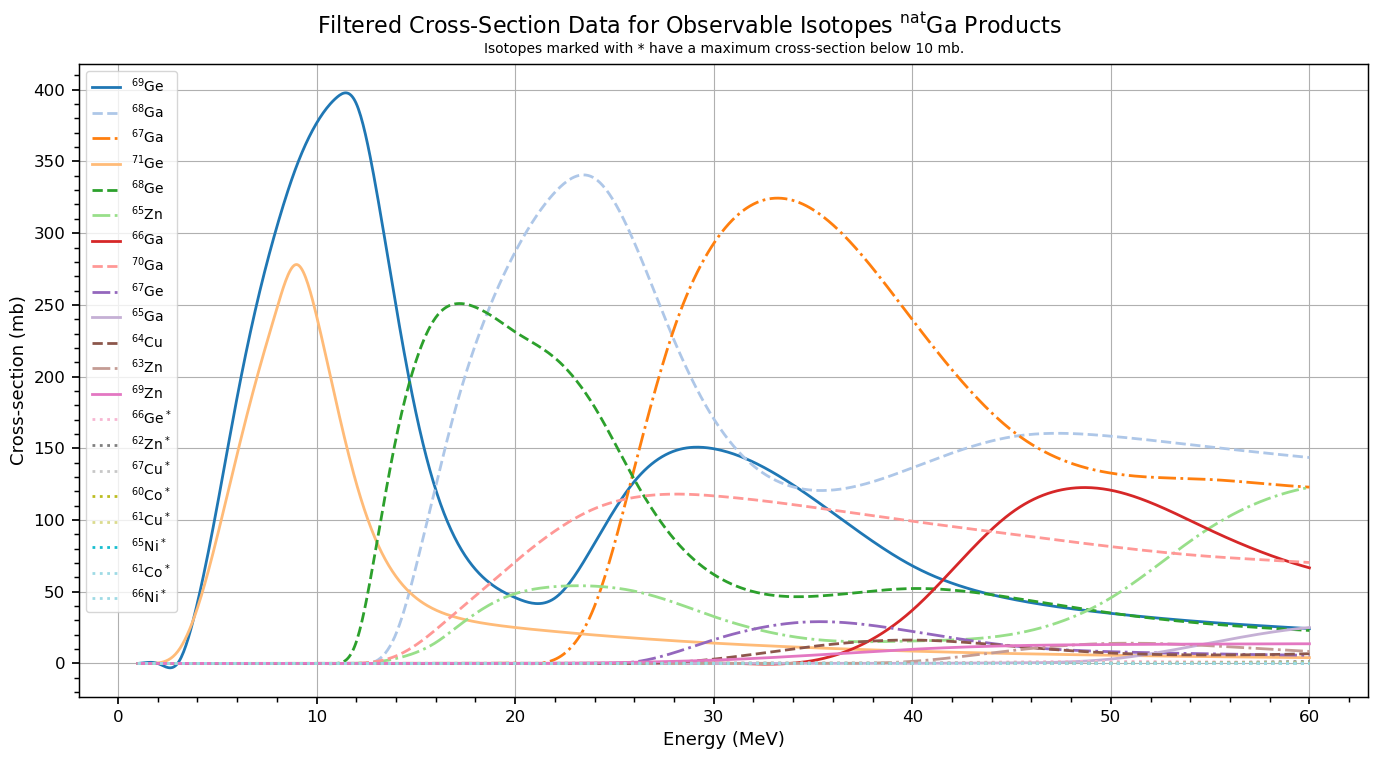

In [81]:
csa_Ga.load_tendl_data(path = tendl_data_path / 'Ga')

csa_Ga.plot_filtered_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Ga Products')
plt.savefig(fig_path / 'Ga_filtered_Cs.pdf')
plt.show()

Found 5/8 isotopes with cross-sections above 0.01 mb:
62CU 66CU 69CU 64GA 62CO


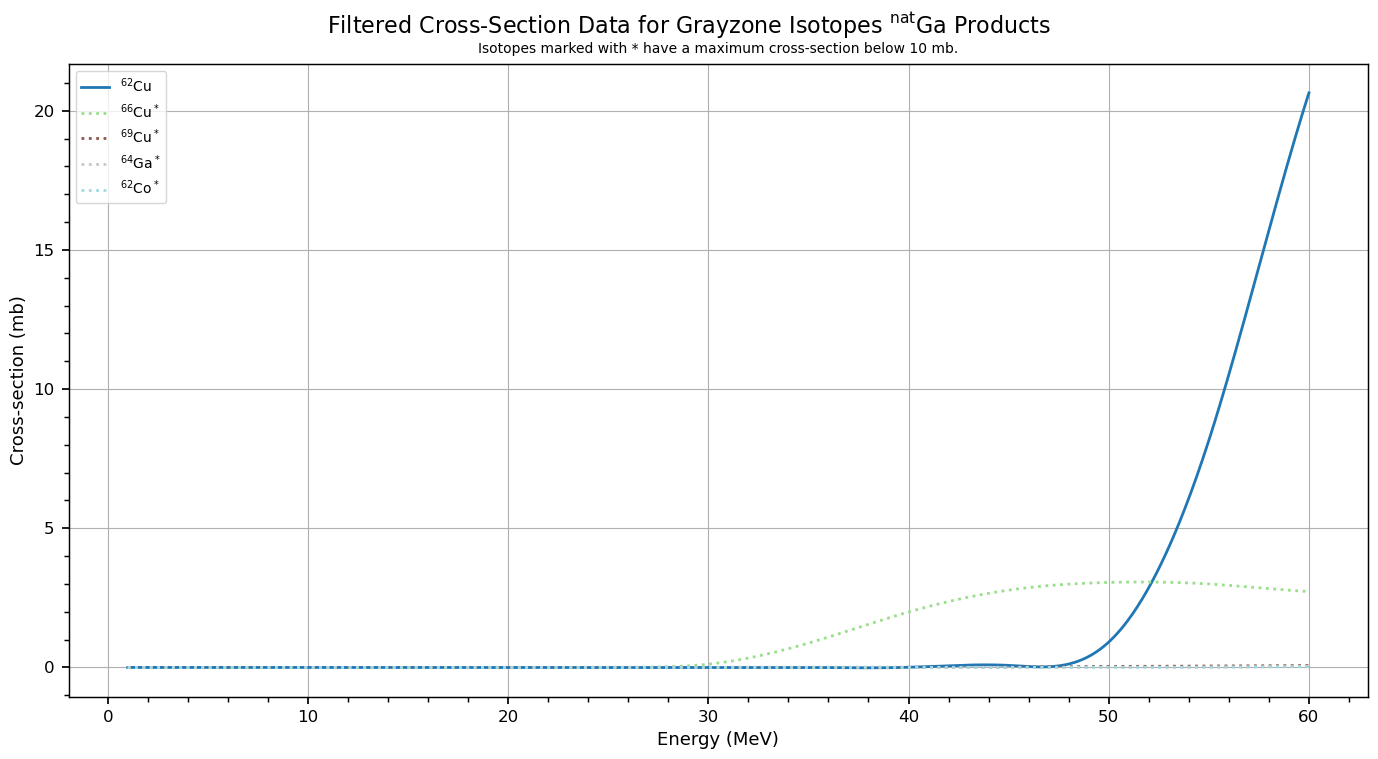

In [82]:
grayzone_products_Ga = csa_Ga.load_tendl_data(path = tendl_data_path / 'Ga', isotopes=csa_Ga.grayzone_isotopes)

csa_Ga.plot_filtered_Cs(title=r'Filtered Cross-Section Data for Grayzone Isotopes $^{\text{nat}}$Ga Products', isotopes=grayzone_products_Ga)
plt.savefig(fig_path / 'Ga_grayzone_filtered_Cs.pdf')
plt.show()

#### Sn (Tin)

In [83]:
# csa_Sn.save_tendl_data(path = tendl_data_path / 'Sn')

Found 31/45 isotopes with cross-sections above 0.01 mb:
119SB 117SB 120SB 116SB 115SB 113SN 122SB 121SN 124SB 117IN 123SN 111SN 112IN 111IN 110IN 110SN 109IN 109SN 109CD 108IN 107IN 108SN 107CD 115CD 105CD 125SB 106AG 111AG 117CD 118CD 105AG


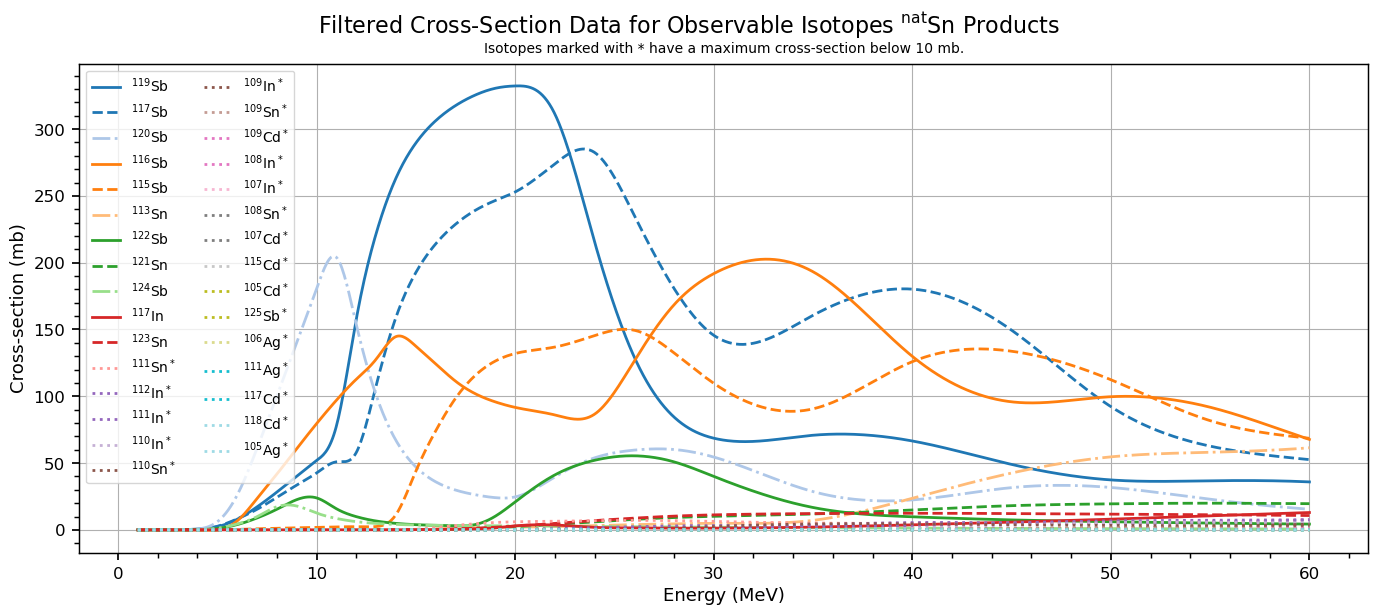

In [84]:
csa_Sn.load_tendl_data(path = tendl_data_path / 'Sn')

csa_Sn.plot_filtered_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Sn Products')
plt.legend(loc='upper left', ncol=2)
plt.savefig(fig_path / 'Sn_filtered_Cs.pdf')
plt.show()

### Monitor Foils Cross Sections

#### Cu (Copper)

In [85]:
# csa_Cu.save_tendl_data(path = tendl_data_path / 'Cu')

Found 18/18 isotopes with cross-sections above 0.01 mb:
63ZN 65ZN 61CU 64CU 62ZN 57CO 58CO 60CU 60CO 56CO 57NI 55FE 61CO 54MN 59FE 56MN 56NI 55CO


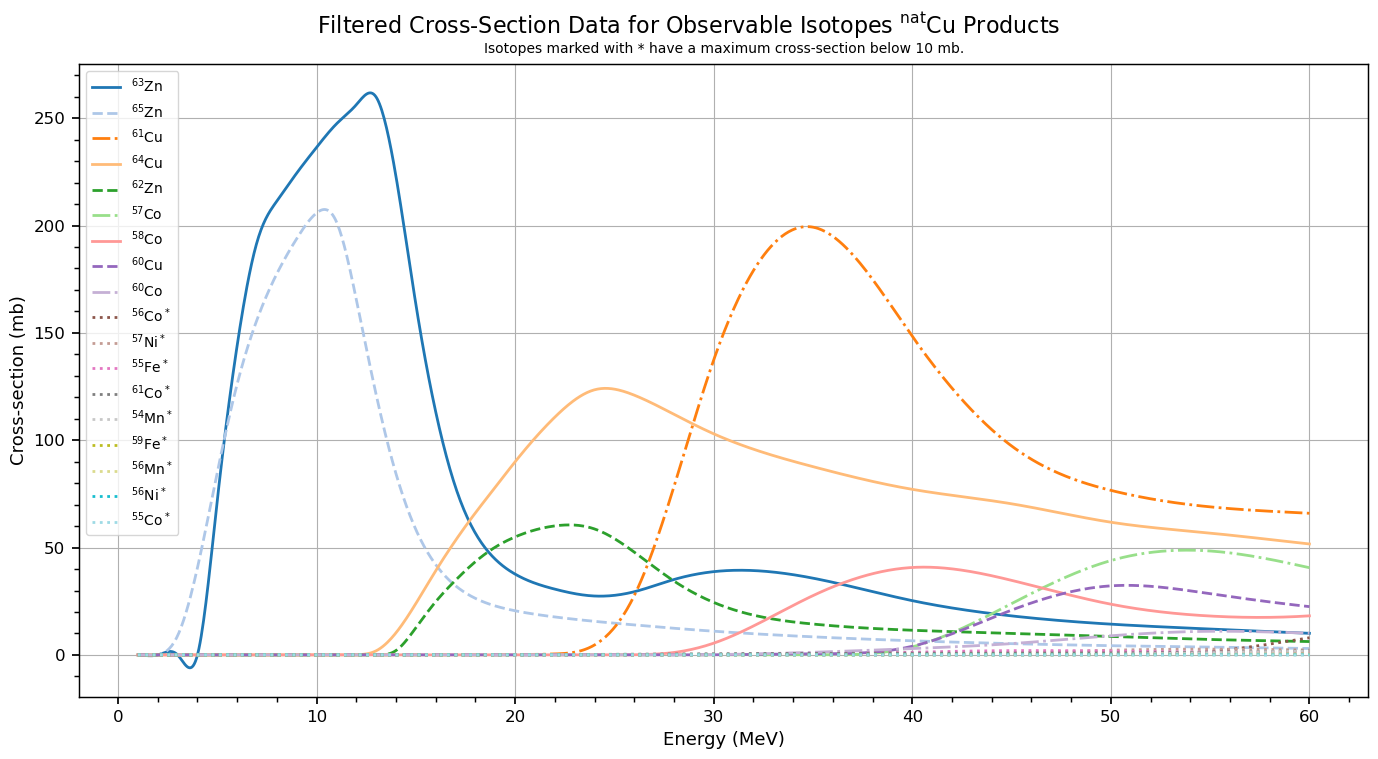

In [86]:
csa_Cu.load_tendl_data(path = tendl_data_path / 'Cu')

csa_Cu.plot_filtered_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Cu Products')
plt.savefig(fig_path / 'Cu_filtered_Cs.pdf')
plt.show()

#### Ni (Nickel)

In [87]:
# csa_Ni.save_tendl_data(path = tendl_data_path / 'Ni')

Found 21/24 isotopes with cross-sections above 0.01 mb:
57CO 56CO 57NI 55FE 60CU 58CO 55CO 52MN 56NI 61CU 54MN 64CU 60CO 51CR 61CO 52FE 51MN 49V 49CR 59FE 56MN


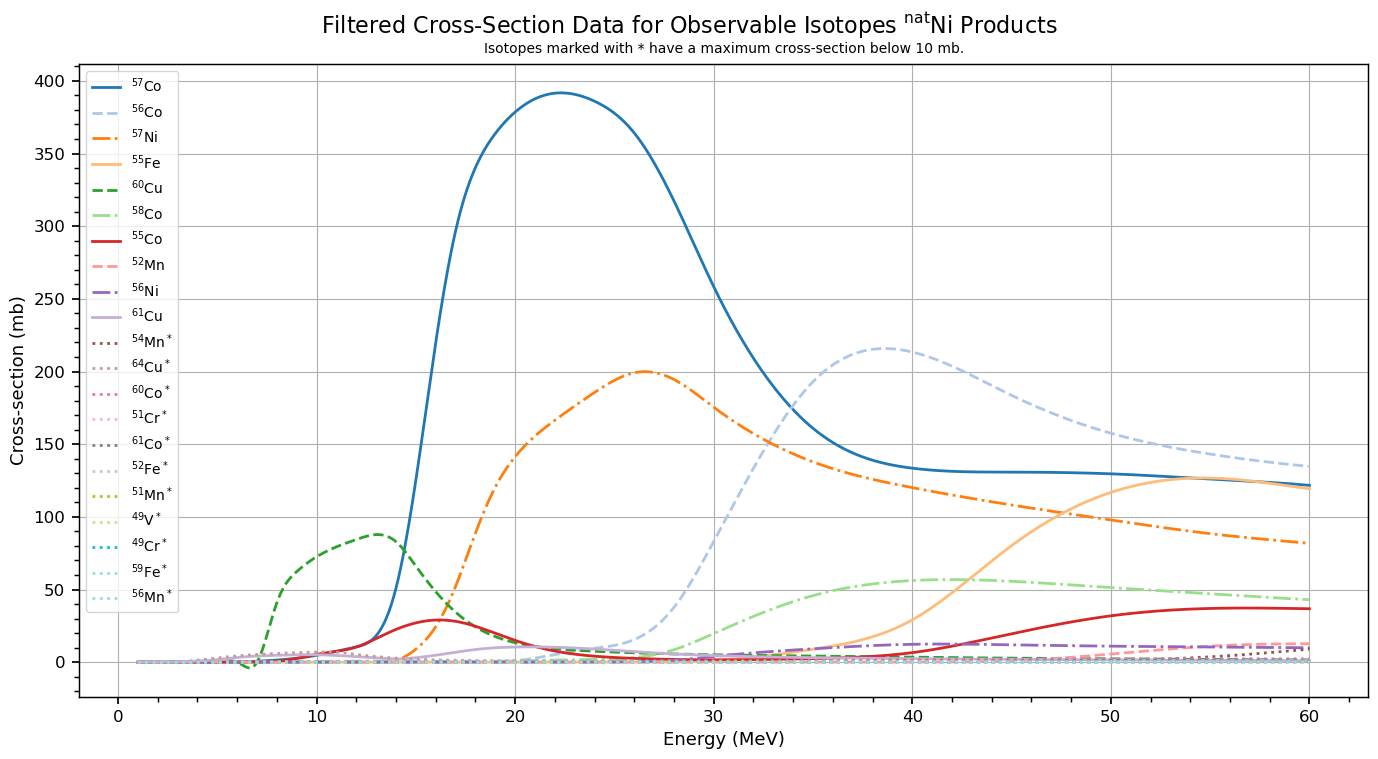

In [88]:
csa_Ni.load_tendl_data(path = tendl_data_path / 'Ni')

csa_Ni.plot_filtered_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Ni Products')
plt.savefig(fig_path / 'Ni_filtered_Cs.pdf')
plt.show()

# Part 3: Calculating Counting Times

               name compound  areal_density       mu_E
0              Ni01       Ni        22.2375  54.903130
1              Sn01       Sn         7.2820  54.790280
2    Kapton_01front   Kapton         3.6920  54.747523
3              Ga01       Ga        29.5400  54.618303
4     Kapton_01back   Kapton         3.6920  54.489513
5              Cu01       Cu        22.3725  54.384443
6   Al_degrader_E01       Al       261.5000  53.097258
7              Ni02       Ni        22.2375  51.792267
8              Sn02       Sn         7.2820  51.674630
9    Kapton_02front   Kapton         3.6920  51.630247
10             Ga02       Ga        29.5400  51.494817
11    Kapton_02back   Kapton         3.6920  51.360450
12             Cu02       Cu        22.3725  51.250940
13  Al_degrader_E02       Al       261.5000  49.903274
14             Ni03       Ni        22.2375  48.537443
15             Sn03       Sn         7.2820  48.414590
16   Kapton_03front   Kapton         3.6920  48.367880
17        

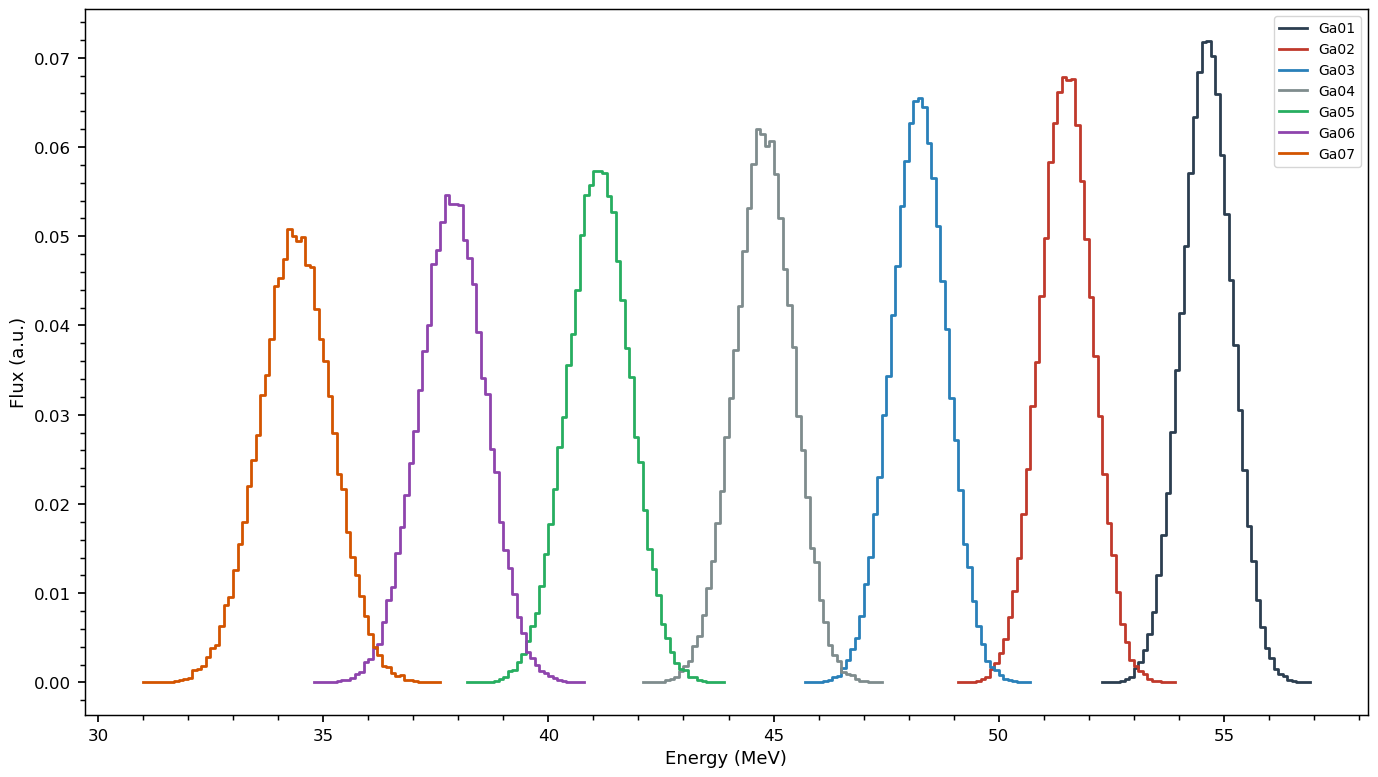

In [89]:
import curie as ci
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Compound must be specified, and enough info to determine areal density
## Units:
## thickness: mm
## mass: g
## area: cm^2
## ad (areal density): mg/cm^2
## density: g/cm^3

x_kapton = 0.013
x_silicone = 0.013

ad_degrader_a = 599.   #2.24 mm
ad_degrader_b = 415.0   #1.55 mm
ad_degrader_c = 261.5   #0.97 mm
# ad_degrader_d = 599.0
ad_degrader_e = 68.3   #0.256 mm
ad_degrader_h = 33.8

ad_be_backing = 4.425     #23.9130435 microns

# for i in np.arange(1,11):
# 	print(i)

# 
# 55 MeV stack
# 

stack = []
for i,mult in zip(np.arange(1,8),[ad_degrader_c,ad_degrader_c,ad_degrader_c,ad_degrader_c,3*ad_degrader_e,3*ad_degrader_e,3*ad_degrader_e]):
    d = [
    {'compound':'Ni', 'name':'Ni'+str(i).zfill(2), 't':0.025},
            {'compound':'Sn', 'name':'Sn'+str(i).zfill(2), 't':0.010},
            {'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'front', 't':2*x_kapton},
            # {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'front', 't':x_silicone},
            {'compound':'Ga', 'name':'Ga'+str(i).zfill(2), 't':0.050},
            # {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'back', 't':x_silicone},
            {'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'back', 't':2*x_kapton},
            {'compound':'Cu', 'name':'Cu'+str(i).zfill(2), 't':0.025},
            {'compound':'Al', 'name':'Al_degrader_E'+str(i).zfill(2), 'ad':mult}]
    # print(d)
    stack = stack + d
    # stack.update(d)

# 
# 30 MeV stack
# 

# stack = []
# for i,mult in zip(np.arange(8,15),[2*ad_degrader_e,2*ad_degrader_e,2*ad_degrader_e,ad_degrader_e,ad_degrader_e,68.75,0.01]):
# 	d = [{'compound':'Ni', 'name':'Ni'+str(i).zfill(2), 't':0.025},
# 			{'compound':'Sn', 'name':'Sn'+str(i).zfill(2), 't':0.010},
# 			{'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'front', 't':2*x_kapton},
# 			# {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'front', 't':x_silicone},
# 			{'compound':'Ga', 'name':'Ga'+str(i).zfill(2), 't':0.050},
# 			# {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'back', 't':x_silicone},
# 			{'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'back', 't':2*x_kapton},
# 			{'compound':'Cu', 'name':'Cu'+str(i).zfill(2), 't':0.025},
# 			{'compound':'Al', 'name':'Al_degrader_E'+str(i).zfill(2), 'ad':mult}]
# 	# print(d)
# 	stack = stack+ d
# 	# stack.update(d)

# print(stack)


# # cm = ci.Compound('RbF', density=3.56)
# # print(cm.weights)


# print('Running...')
# # st = ci.Stack(stack, compounds={'RbF':{'Cu':-66, 'Zn':-33}}, E0=60.0)

st = ci.Stack(stack, E0=55.0, particle='p', dE0=0.55, N=1E4, max_steps=100)
# st = ci.Stack(stack, E0=30.0, particle='p', dE0=0.30, N=1E4, max_steps=100)
# st.saveas('lbnl_GaSn_stack_30MeV.csv')
# st.saveas('lbnl_GaSn_stack_30MeV.db')
# st.saveas('lbnl_GaSn_stack_55MeV.csv')
# st.saveas('lbnl_GaSn_stack_55MeV.db')
# # st.saveas('lbnl_w_stack.db')
# # st.saveas('lbnl_pa_stack.csv')
# st.summarize()
foil_properties = st.stack[['compound', 'areal_density', 'mu_E']].drop_duplicates('compound')
print(st.stack[['name', 'compound', 'areal_density', 'mu_E']])
st.plot('Ga')

In [90]:
for foil in st.stack.itertuples():
    print(foil.name, foil.compound, foil.areal_density, foil.mu_E)

Ni01 Ni 22.2375 54.903130000000004
Sn01 Sn 7.282000000000001 54.790279999999996
Kapton_01front Kapton 3.6919999999999997 54.74752333333333
Ga01 Ga 29.540000000000006 54.618303333333344
Kapton_01back Kapton 3.6919999999999997 54.489513333333335
Cu01 Cu 22.372500000000002 54.38444333333334
Al_degrader_E01 Al 261.5 53.097258
Ni02 Ni 22.2375 51.79226666666666
Sn02 Sn 7.282000000000001 51.67463
Kapton_02front Kapton 3.6919999999999997 51.630246666666665
Ga02 Ga 29.540000000000006 51.49481666666667
Kapton_02back Kapton 3.6919999999999997 51.36045
Cu02 Cu 22.372500000000002 51.25094
Al_degrader_E02 Al 261.5 49.903274
Ni03 Ni 22.2375 48.537443333333336
Sn03 Sn 7.282000000000001 48.414590000000004
Kapton_03front Kapton 3.6919999999999997 48.36788
Ga03 Ga 29.540000000000006 48.22763
Kapton_03back Kapton 3.6919999999999997 48.086560000000006
Cu03 Cu 22.372500000000002 47.97198333333334
Al_degrader_E03 Al 261.5 46.554673333333334
Ni04 Ni 22.2375 45.11263
Sn04 Sn 7.282000000000001 44.98291666666667

In [91]:
print(foil_properties)

  compound  areal_density       mu_E
0       Ni        22.2375  54.903130
1       Sn         7.2820  54.790280
2   Kapton         3.6920  54.747523
3       Ga        29.5400  54.618303
5       Cu        22.3725  54.384443
6       Al       261.5000  53.097258


In [92]:
from scipy.constants import Avogadro


@dataclass 
class GammaActivity:
    """
    Dataclass to store counting time t_c to count 10'000 decays, as a function of delay time t_d. 
    """
    source_isotope: str 
    foil_number: int
    energy: float
    decay_constant: float

    t_d: np.ndarray 
    t_c: np.ndarray
    
    
    


class Foil:
    def __init__(self, target: str, foil_number: int, areal_density: float, mu_E: float, Φ: float = 6.24e11, t_irr: float = 60*60):
        self.target = target
        self.foil_number = str.zfill(foil_number, 2)
        self.areal_density = areal_density
        self.mu_E = mu_E
        
        self.Φ = Φ  # Flux in protons/cm^2/s
        self.t_irr = t_irr  # Irradiation time in seconds   
        
        
        
    def A0(self, σ, N_T, Φ, t_irr, λ):
        """
        Calculates the activity A0 from the cross-section σ, target atom density N_T, flux Φ, irradiation time t_irr, and decay constant λ.
        
        Parameters
        ----------
        σ : float
            Cross-section in barns (b).
        N_T : float
            Target atom density in atoms/cm^2.
        Φ : float
            Flux in protons/cm^2/s.
        t_irr : float
            Irradiation time in seconds.
        λ : float
            Decay constant in decays/s.
            
        Returns
        -------
        float
            Activity A0 in Bq.
        """
        return σ * N_T * Φ * (1 - np.exp(-λ * t_irr))
        
    def load_npy(self, path: Path) -> tuple[np.ndarray, np.ndarray]:
        """
        Loads cross-section data from a .npy file.
        
        Parameters
        ----------
        path : Path
            The path to the .npy file.
            
        Returns
        -------
        tuple[np.ndarray, np.ndarray]
            A tuple containing two numpy arrays: energies and cross-sections.
        """
        if not path.exists():
            raise FileNotFoundError(f"File: {path} does not exist. Returning empty arrays.")
            
        
        E, Cs = np.load(path)
        return E, Cs
    

class CountingAnalysis:
    """
    Class to analyxe the time needed to count decays of isotopes produced in a foil.
    """
    
    def __init__(self, foil: Foil, path: Path):
        """
        Initializes the CountingAnalysis class.
        
        Parameters
        ----------
        foil : Foil
            The foil object containing target material and properties.
        path : Path
            The path to the directory where cross-section data files are stored.
        """
        self.foil = foil
        self.path = path
        
        E, Cs = foil.load_npy(path / f'{foil.target.title()}')
        beam_energy = foil.mu_E
        idx = np.argmin(np.abs(E - beam_energy))
        self.σ = Cs[idx] * 1e-3 * 1e-28
        
    

In [112]:
from scipy.constants import Avogadro

def A0_from_Cs(σ, N_T, Φ, t_irr, λ):
    """
    Calculates the activity A0 from the cross-section σ, target atom density N_T, flux Φ, irradiation time t_irr, and decay constant λ.
    
    Parameters
    ----------
    σ : float
        Cross-section in barns (b).
    N_T : float
        Target atom density in atoms/cm^2.
    Φ : float
        Flux in protons/cm^2/s.
    t_irr : float
        Irradiation time in seconds.
    λ : float
        Decay constant in decays/s.
        
    Returns
    -------
    float
        Activity A0 in Bq.
    """
    return σ * N_T * Φ * (1 - np.exp(-λ * t_irr))

def counting_time(A0, I_γ, t_d, ε_γ, λ, N_c = 10_000):
    """
    Calculates the counting time t_c to count N_c decays, as a function of delay time t_d.
    
    Parameters
    ----------
    A0 : float
        Initial activity in Bq.
    I_γ : float
        Intensity of the gamma line.
    t_d : np.ndarray
        Delay time in seconds.
    ε_γ : float
        Energy of the gamma line in MeV.
    λ : float
        Decay constant in decays/s.
    N_c : int, optional
        Number of counts to achieve. Defaults to 10,000.
        
    Returns
    -------
    np.ndarray
        Counting time in seconds.
    """
    t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
    return t_c


Φ = 6.24e11 # protons/cm^2/s
t_irr = 60*60 # s
λ = ci.Isotope('69GE').decay_const() # decays/s
E, Cs = csa_Ga._load_npy(tendl_data_path / 'Ga' / '69Ge.npy') # Mev, mb

idx = np.argmin(np.abs(E - 55.0))  

σ = Cs[idx] * 1E-27 # mb to cm^2

A = foil_properties[foil_properties['compound'] == 'Ga']['areal_density'].values[0] * 1E-3  #  g/cm^2

M = ci.Isotope('69GE').mass # g/mol or amu

N_T = A * Avogadro / M  # atoms/cm^2

A0 = σ*N_T*Φ*(1 - np.exp(-λ*t_irr)) # 
print(A0) 

81150.0931573607


In [94]:
print(ci.Isotope('69GE').gammas(I_lim=1, dE_511=.1))

    energy  intensity  unc_intensity
0   318.63       1.55            0.2
1   574.11      13.30            1.8
2   871.98      11.90            1.6
3  1106.77      36.00            1.8
4  1336.60       4.50            0.6


In [95]:
E, Cs = csa_Ga._load_npy(tendl_data_path / 'Ga' / '69Ge.npy') # Mev, mb

print(np.abs(E - 30).argmin())

491


/tmp/ipykernel_42645/2988253617.py:51: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_42645/2988253617.py:51: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_42645/2988253617.py:51: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_42645/2988253617.py:51: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_42645/2988253617.py:51: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_42645/2988253617.py:51: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_42645/2988253617.py:51: RuntimeWarnin

2611


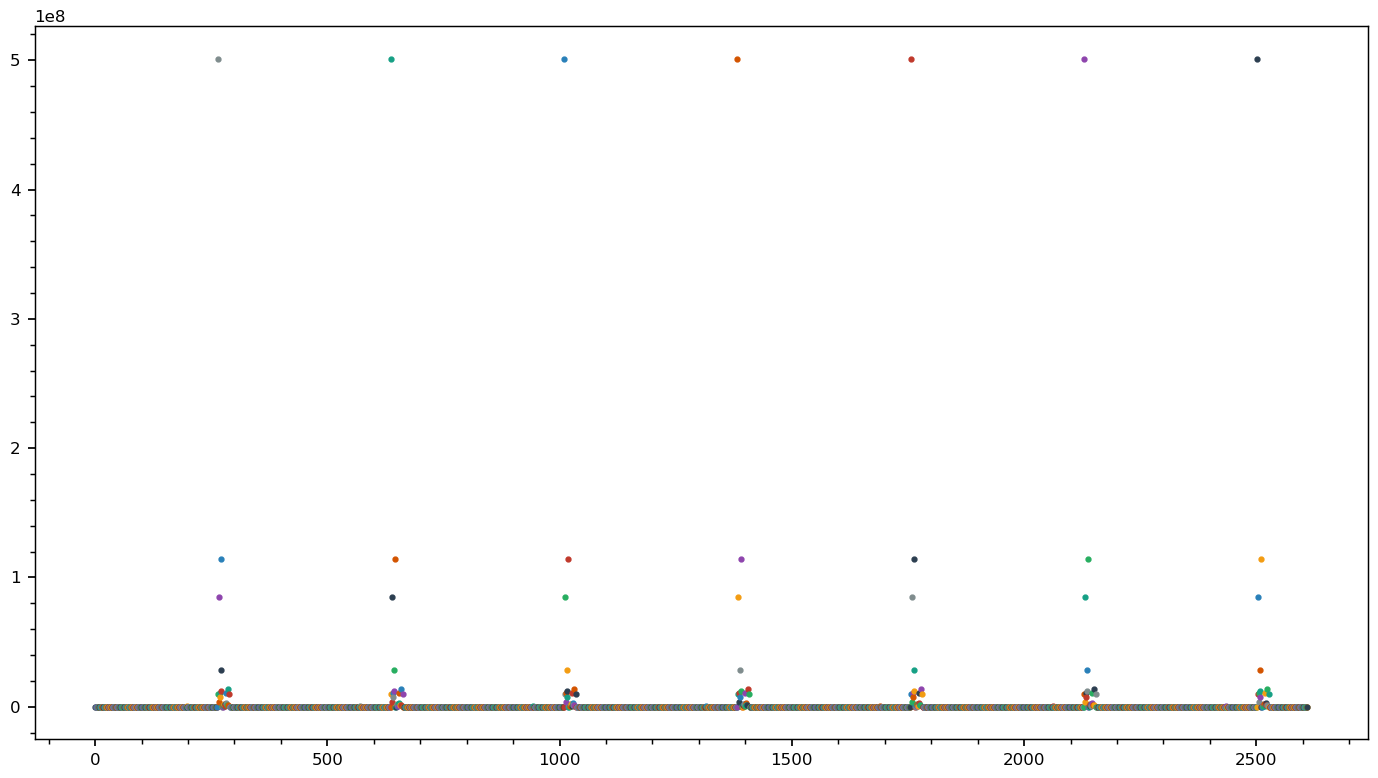

In [ ]:
n = 5
products = {'Ni': csa_Ni.filter_products_Cs()[:], 
            'Sn': csa_Sn.filter_products_Cs()[:], 
            'Cu': csa_Cu.filter_products_Cs()[:], 
            'Ga': csa_Ga.filter_products_Cs()[:]}


Φ = 6.24e11  # protons/cm^2/s
t_irr = 60 * 60  # s
beam_energy = 55 # MeV

i = 0
for foil in st.stack.itertuples():
    element = foil.compound
    # csa = CrossSectionAnalysis(target=foil.compound, particle_beam='proton', n_alpha=3, max_half_life=100, min_half_life=60, grayzone_half_life=10)
    
    if element not in products:
        # print(f"Element {element} not found in products. Skipping.")
        continue
    
    A = foil.areal_density * 1E-3  # g/cm^2
    for product in products[element]:
        iso_name, (E, Cs) = product
        iso = ci.Isotope(iso_name)
        λ = iso.decay_const()  # decays/s
        M = iso.mass
        N_T = A * Avogadro / M  # atoms/cm^2
        idx = np.abs(E - beam_energy).argmin()
        σ = Cs[idx] * 1E-27 # mb to cm^2
        
        A0 = A0_from_Cs(σ, N_T, Φ, t_irr, λ)  # Activity in Bq
        
        for gamma in iso.gammas(I_lim=1, dE_511=.1).itertuples():
            E_γ = gamma.energy  # MeV
            # TODO: Divide by 100?
            I_γ = gamma.intensity  # Relative intensity
            ε_γ = efficiency_curve(E_γ, *efficiency_curve_params)  
            t_c = counting_time(A0, I_γ, 0, ε_γ, λ)  # Counting time in seconds
            plt.scatter(i, t_c)
            
            if t_c == np.NaN:
                print(f"Skipping NaN value for isotope {iso_name} with energy {E_γ} MeV.")
                print(f"Parameters: σ={σ:.2e}, N_T={N_T:.2e}, λ={λ:.2e}")
            
            i += 1
  

print(i)
plt.show()

In [100]:
n = 5
products = {'Ni': csa_Ni.filter_products_Cs()[:], 
            'Sn': csa_Sn.filter_products_Cs()[:], 
            'Cu': csa_Cu.filter_products_Cs()[:], 
            'Ga': csa_Ga.filter_products_Cs()[:]}


Φ = 6.24e11  # protons/cm^2/s
t_irr = 60 * 60  # s
beam_energy = 30 # MeV

# List to store results
results_list = []

for foil in st.stack.itertuples():
    element = foil.compound
    
    if element not in products:
        continue
    
    A = foil.areal_density * 1E-3  # g/cm^2
    for product in products[element]:
        iso_name, (E, Cs) = product
        iso = ci.Isotope(iso_name)
        λ = iso.decay_const()  # decays/s
        M = iso.mass
        N_T = A * Avogadro / M  # atoms/cm^2
        idx = np.abs(E - foil.mu_E).argmin() # Use foil-specific energy
        σ = Cs[idx] * 1E-27 # Convert mb to cm^2
        
        if σ < 0:
            continue
        
        A0 = A0_from_Cs(σ, N_T, Φ, t_irr, λ)  # Activity in Bq
        
        for gamma in iso.gammas(I_lim=1, dE_511=.1).itertuples():
            E_γ = gamma.energy  # keV
            I_γ = gamma.intensity / 100.0  # Convert intensity from % to fraction
            
            if I_γ == 0 or A0 == 0:
                continue

            ε_γ = efficiency_curve(E_γ, *efficiency_curve_params)  
            t_c = counting_time(A0, I_γ, np.arange(0, 3600), ε_γ, λ)  # Counting time in seconds
            
            # Create a dictionary for the current result
            result_entry = {
                'foil_name': foil.name,
                'foil_index': foil.Index,
                'target_material': element,
                'beam_energy_MeV': foil.mu_E,
                'product_isotope': iso_name,
                'cross_section_cm2': σ,
                'initial_activity_Bq': A0,
                'gamma_energy_keV': E_γ,
                'gamma_intensity': I_γ,
                'counting_time_s': t_c,
                'decay_constant_s-1': λ,
            }
            results_list.append(result_entry)

# Create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)

# Display the first few rows of the DataFrame
results_df.head()
results_df.tail()

/tmp/ipykernel_42645/940843903.py:25: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - N_c*λ/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_42645/940843903.py:25: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - N_c*λ/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_42645/940843903.py:25: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - N_c*λ/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_42645/940843903.py:25: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - N_c*λ/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_42645/940843903.py:25: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - N_c*λ/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_42645/940843903.py:25: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - N_c*λ/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_42645/940843903.py:25: RuntimeWarning: invalid value en

,foil_name,foil_index,target_material,beam_energy_MeV,product_isotope,cross_section_cm2,initial_activity_Bq,gamma_energy_keV,gamma_intensity,counting_time_s,decay_constant_s-1
2502,Cu07,47,Cu,34.053453,56NI,3.685206e-33,0.002627,269.50,0.365,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.000001
2503,Cu07,47,Cu,34.053453,56NI,3.685206e-33,0.002627,480.44,0.365,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.000001
2504,Cu07,47,Cu,34.053453,56NI,3.685206e-33,0.002627,749.95,0.495,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.000001
2505,Cu07,47,Cu,34.053453,56NI,3.685206e-33,0.002627,811.85,0.860,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.000001
2506,Cu07,47,Cu,34.053453,56NI,3.685206e-33,0.002627,1561.80,0.140,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.000001


In [98]:
def func(a = ...):
    print(a)
    

if ...:
    print("This is a test.")

This is a test.
